# Assignment 6 - [30 points]

## <u>Case Study 1</u>: Seattle Airbnb Listing Analysis - Full Dataset - *Mixed Data Types*

Suppose that you work as a data scientist at Airbnb. You'd like to learn more about the main different types of Airbnb listings in the Seattle area and then use this information to advertise these different types of listings to interested customers. 

The following dataset is a sample of available Airbnb listings in Seattle, WA. These listings were collected in January 2016, and filtered to just contain listings from the five most popular Seattle neighborhoods (for Airbnb listings) and just contain listings that are either in a house or apartment property. Rows with missing values have already been dropped from the dataset.

This dataset contains the following variables.

**Listing Information**
The dataset contains the following information about the Airbnb *listing*:
* <u>price</u>: price of the listing (per night)(in US dollars)
* <u>review_scores_rating</u>: the average rating of the listing [0,100] (100 is the best)
* <u>number_of_reviews</u>: the number of reviews for the listing
* <u>security_deposit</u>: the security deposit required for the listing (in US dollars)
* <u>cleaning_fee</u>: the cleaning fee required for the listing (in US dollars)
* <u>neighborhood</u>: the neighborhood of Seattle the listing is located in
* <u>property_type</u>: is the listing in a 'House' or 'Apartment'
* <u>room_type</u>: is the listing a 'Entire home/apt', 'Private room', or 'Shared room'
* <u>accommodates</u>: how many guests will the listing accommodate
* <u>bathrooms</u>:how many bathrooms does the listing have
* <u>beds</u>: how many beds does the listing have

**Host Information**
The dataset also contains the following information about the *host* of the given Airbnb listing:
* <u>host_is_superhost</u>: is the host a "superhost": t=True, f=False
* <u>host_has_profile_pic</u>: does the host have a profile pic in their bio: t=True, f=False
* <u>host_response_time</u>: how fast will the host respond to requests (on average)
* <u>host_acceptance_rate</u>: what percent of booking requests will the host accept

### <u>Research Goals</u>:

In this analysis, we have the following research goals.

1. Identify larger "main clusters" of Airbnb listings in the Seattle area. In general, we would like for most of our listings to be clustered in with a larger cluster, rather than be separated as small or singleton clusters.
2. We would also like to identify potential sub-clusters of listings within each of the "main clusters."
3. What are the most dissimilar clusters of Airbnb listings in this dataset? What makes them so dissimilar?
4. What attributes characterize each of these clusters and sub-clusters?

#### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from skfuzzy.cluster import cmeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, silhouette_samples, silhouette_score

from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler


from kmodes.kprototypes import KPrototypes
from gower import gower_matrix

## 1. Data Preprocessing and Cleaning

### 1.1. Original Dataset
Read the seattle_airbnb_listings_cleaned.csv into a dataframe. This dataframe has already been cleaned (rows with missing values have already been dropped).

In [5]:
df = pd.read_csv("seattle_airbnb_listings_cleaned.csv")

In [6]:
df.head()

price  review_scores_rating  number_of_reviews  security_deposit  \
0    300                   100                 24               500   
1    149                    96                 11               300   
2     95                    95                 79               150   
3    105                   100                 13               500   
4    140                    99                 30               250   

   cleaning_fee neighborhood property_type        room_type  accommodates  \
0            95  Wallingford         House  Entire home/apt             5   
1           105  Wallingford     Apartment  Entire home/apt             6   
2            40  Wallingford     Apartment  Entire home/apt             3   
3            50  Wallingford         House     Private room             2   
4            65  Wallingford         House  Entire home/apt             2   

   bathrooms  bedrooms  beds  host_response_time  host_response_rate  \
0        1.5         3     3  within a few hours                 1.0   
1        1.0         2     3      within an hour                 1.0   
2        1.0         1     2      within an hour                 1.0   
3        2.0         1     1  within a few hours                 1.0   
4        1.0         1     1      within an hour                 1.0   

   host_acceptance_rate host_is_superhost host_has_profile_pic  \
0                     1                 t                    t   
1                     1                 f                    t   
2                     1                 f                    t   
3                     1                 t                    t   
4                     1                 t                    t   

  host_identity_verified  
0                      t  
1                      t  
2                      t  
3                      t  
4                      t

### 1.2. Numerical Variable Scaling

Next, we would like to cluster this dataset with the k-prototypes clustering algorithm and would like to determine if we should scale our numerical variables before running this algorithm.


#### 1.2.1. Describe the numerical variables

First, calculate the mean, standard deviation, minimum, maximum, median, Q1, and Q3 for each of the numerical variables in the dataset.

In [7]:
df.describe()

price  review_scores_rating  number_of_reviews  security_deposit  \
count  279.000000            279.000000         279.000000        279.000000   
mean   133.810036             93.125448          22.455197        259.849462   
std     93.442071              9.110159          25.296457        167.199055   
min     35.000000             20.000000           1.000000         95.000000   
25%     85.000000             92.000000           4.500000        150.000000   
50%    114.000000             96.000000          12.000000        250.000000   
75%    150.000000             99.000000          32.000000        350.000000   
max    999.000000            100.000000         124.000000       1900.000000   

       cleaning_fee  accommodates   bathrooms    bedrooms        beds  \
count    279.000000    279.000000  279.000000  279.000000  279.000000   
mean      62.759857      3.659498    1.236559    1.326165    1.917563   
std       38.565319      2.083381    0.565454    0.950802    1.276664   
min        5.000000      1.000000    1.000000    0.000000    1.000000   
25%       35.000000      2.000000    1.000000    1.000000    1.000000   
50%       60.000000      3.000000    1.000000    1.000000    1.000000   
75%       80.000000      4.000000    1.000000    2.000000    2.000000   
max      250.000000     16.000000    3.500000    5.000000   10.000000   

       host_response_rate  host_acceptance_rate  
count          279.000000                 279.0  
mean             0.944659                   1.0  
std              0.089083                   0.0  
min              0.500000                   1.0  
25%              0.900000                   1.0  
50%              1.000000                   1.0  
75%              1.000000                   1.0  
max              1.000000                   1.0

#### 1.2.2. Should we scale?

Do we think that there are some numerical variables that will have a stronger influence on the the k-prototypes algorithm results than others? If so, give a numerical variable that we think will have a strong influence and one that we think will have a weak influence. Why do we think that these variables will have a stronger and weaker effect on k-prototypes, respectively?

Review_score_rating and security_deposit are variables that will have a strong influence on the k-prototype algorithm because they have a high mean than other numerical variables. Bathrooms, bedrooms, and beds are variables that will have a weak influence on the k-prototype algorithm because they have low means. 


<hr>

**Tutorial**:
You can use the **.inverse_transform()** function to unscale a set of numerical values using the same column means and and standard deviations that were used to scale another dataset.

In [5]:
import pandas as pd
tmp1=pd.DataFrame({'x': [1,2,3], 'y': [-1,10,3]})
tmp1

x   y
0  1  -1
1  2  10
2  3   3

In [6]:
from sklearn.preprocessing import StandardScaler
st_tmp=StandardScaler()

st_tmp.fit_transform(tmp1)

array([[-1.22474487, -1.09985336],
       [ 0.        ,  1.31982404],
       [ 1.22474487, -0.21997067]])

In [7]:
tmp2=pd.DataFrame({'x': [0.0,1.0], 'y': [2.-0,-1.0]})
tmp2

x    y
0  0.0  2.0
1  1.0 -1.0

In [8]:
st_tmp.inverse_transform(tmp2)

array([[ 2.        , 13.09212113],
       [ 2.81649658, -0.54606057]])

#### 1.2.3. Scale the numerical variables

Next, create a new dataframe that is comprised of the numerical and categorical variables, where the numerical variables have been scaled. You should scale each of the numerical variables by subtracting their respective means and then dividing by their respective standard deviations.

**Because we will eventually try to 'unscale' the dataframe, you should scale your dataframe using the slightly different technique shown in the tutorial above. (That is, you need to first create an object using JUST the StandardScaler() function, then use this object to scale the numerical values dataframe).**

You should also make a copy of this dataframe that will be used just for clustering and checking clusterability.

In [9]:
dfnew = df[['price','review_scores_rating','number_of_reviews','security_deposit','cleaning_fee','accommodates','bathrooms','beds','host_response_rate','host_acceptance_rate']]

In [10]:
dfnew

price  review_scores_rating  number_of_reviews  security_deposit  \
0      300                   100                 24               500   
1      149                    96                 11               300   
2       95                    95                 79               150   
3      105                   100                 13               500   
4      140                    99                 30               250   
..     ...                   ...                ...               ...   
274    250                    95                  4               250   
275    125                    95                 12               150   
276    100                    98                 10               200   
277    175                    96                 29               500   
278    154                    92                  5               150   

     cleaning_fee  accommodates  bathrooms  beds  host_response_rate  \
0              95             5        1.5     3                1.00   
1             105             6        1.0     3                1.00   
2              40             3        1.0     2                1.00   
3              50             2        2.0     1                1.00   
4              65             2        1.0     1                1.00   
..            ...           ...        ...   ...                 ...   
274           100            16        3.5    10                0.97   
275            45             2        1.0     1                1.00   
276            89             6        1.0     2                1.00   
277            95             6        2.0     3                1.00   
278            85             5        1.0     3                1.00   

     host_acceptance_rate  
0                       1  
1                       1  
2                       1  
3                       1  
4                       1  
..                    ...  
274                     1  
275                     1  
276                     1  
277                     1  
278                     1  

[279 rows x 10 columns]

In [21]:
sc = StandardScaler()
newscale = scaler.fit_transform(dfnew)
scdata = pd.DataFrame(newscale)
scdata

scdata.columns = dfnew.columns
scdata

price  review_scores_rating  number_of_reviews  security_deposit  \
0    1.781731              0.755959           0.061178          1.438896   
1    0.162852              0.316100          -0.453652          0.240568   
2   -0.416084              0.206135           2.239302         -0.658179   
3   -0.308874              0.755959          -0.374447          1.438896   
4    0.066363              0.645994           0.298791         -0.059014   
..        ...                   ...                ...               ...   
274  1.245678              0.206135          -0.730868         -0.059014   
275 -0.094453              0.206135          -0.414049         -0.658179   
276 -0.362479              0.536029          -0.493254         -0.358597   
277  0.441600              0.316100           0.259189          1.438896   
278  0.216458             -0.123760          -0.691265         -0.658179   

     cleaning_fee  accommodates  bathrooms      beds  host_response_rate  \
0        0.837490      0.644582   0.466730  0.849388            0.622341   
1        1.097256      1.125434  -0.419105  0.849388            0.622341   
2       -0.591224     -0.317121  -0.419105  0.064688            0.622341   
3       -0.331458     -0.797972   1.352565 -0.720011            0.622341   
4        0.058191     -0.797972  -0.419105 -0.720011            0.622341   
..            ...           ...        ...       ...                 ...   
274      0.967373      5.933949   4.010069  6.342282            0.284971   
275     -0.461341     -0.797972  -0.419105 -0.720011            0.622341   
276      0.681630      1.125434  -0.419105  0.064688            0.622341   
277      0.837490      1.125434   1.352565  0.849388            0.622341   
278      0.577724      0.644582  -0.419105  0.849388            0.622341   

     host_acceptance_rate  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
..                    ...  
274                   0.0  
275                   0.0  
276                   0.0  
277                   0.0  
278                   0.0  

[279 rows x 10 columns]

In [26]:
cat = df[['neighborhood','property_type','room_type','host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified']]

In [27]:
X = scdata.copy()

X[['neighborhood','property_type','room_type','host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified']] = df[['neighborhood','property_type','room_type','host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified']]
X

price  review_scores_rating  number_of_reviews  security_deposit  \
0    1.781731              0.755959           0.061178          1.438896   
1    0.162852              0.316100          -0.453652          0.240568   
2   -0.416084              0.206135           2.239302         -0.658179   
3   -0.308874              0.755959          -0.374447          1.438896   
4    0.066363              0.645994           0.298791         -0.059014   
..        ...                   ...                ...               ...   
274  1.245678              0.206135          -0.730868         -0.059014   
275 -0.094453              0.206135          -0.414049         -0.658179   
276 -0.362479              0.536029          -0.493254         -0.358597   
277  0.441600              0.316100           0.259189          1.438896   
278  0.216458             -0.123760          -0.691265         -0.658179   

     cleaning_fee  accommodates  bathrooms      beds  host_response_rate  \
0        0.837490      0.644582   0.466730  0.849388            0.622341   
1        1.097256      1.125434  -0.419105  0.849388            0.622341   
2       -0.591224     -0.317121  -0.419105  0.064688            0.622341   
3       -0.331458     -0.797972   1.352565 -0.720011            0.622341   
4        0.058191     -0.797972  -0.419105 -0.720011            0.622341   
..            ...           ...        ...       ...                 ...   
274      0.967373      5.933949   4.010069  6.342282            0.284971   
275     -0.461341     -0.797972  -0.419105 -0.720011            0.622341   
276      0.681630      1.125434  -0.419105  0.064688            0.622341   
277      0.837490      1.125434   1.352565  0.849388            0.622341   
278      0.577724      0.644582  -0.419105  0.849388            0.622341   

     host_acceptance_rate neighborhood property_type        room_type  \
0                     0.0  Wallingford         House  Entire home/apt   
1                     0.0  Wallingford     Apartment  Entire home/apt   
2                     0.0  Wallingford     Apartment  Entire home/apt   
3                     0.0  Wallingford         House     Private room   
4                     0.0  Wallingford         House  Entire home/apt   
..                    ...          ...           ...              ...   
274                   0.0      Fremont         House  Entire home/apt   
275                   0.0      Fremont     Apartment  Entire home/apt   
276                   0.0      Fremont     Apartment  Entire home/apt   
277                   0.0      Fremont         House  Entire home/apt   
278                   0.0      Fremont         House  Entire home/apt   

     host_response_time host_is_superhost host_has_profile_pic  \
0    within a few hours                 t                    t   
1        within an hour                 f                    t   
2        within an hour                 f                    t   
3    within a few hours                 t                    t   
4        within an hour                 t                    t   
..                  ...               ...                  ...   
274  within a few hours                 f                    t   
275  within a few hours                 t                    t   
276      within an hour                 f                    t   
277  within a few hours                 f                    t   
278      within an hour                 f                    t   

    host_identity_verified  
0                        t  
1                        t  
2                        t  
3                        t  
4                        t  
..                     ...  
274                      t  
275                      t  
276                      t  
277                      t  
278                      t  

[279 rows x 17 columns]

### 1.3. Gower's distance matrix

Next, use this resulting copied dataframe from 1.2.3 to create a Gower's distance matrix for the Airbnb listings.

In [29]:
dist_mat = gower_matrix(X)
dist_mat

array([[0.        , 0.21944802, 0.2697147 , ..., 0.2891037 , 0.14629324,
        0.22592035],
       [0.21944802, 0.        , 0.07534599, ..., 0.07739875, 0.21911365,
        0.13737465],
       [0.2697147 , 0.07534599, 0.        , ..., 0.11949195, 0.2724411 ,
        0.18402632],
       ...,
       [0.2891037 , 0.07739875, 0.11949195, ..., 0.        , 0.17406343,
        0.08196895],
       [0.14629324, 0.21911365, 0.2724411 , ..., 0.17406343, 0.        ,
        0.11578206],
       [0.22592035, 0.13737465, 0.18402632, ..., 0.08196895, 0.11578206,
        0.        ]], dtype=float32)

## 2. Clusterability

### 2.1. t-SNE Plots
Using 6 different perplexity values and at least two random states for each perplexity value, map this **distance matrix** onto a two-dimensional dataset with the t-SNE algorithm. Show your projected coordinates in a scatterplot for each combination of random states and perplexity value.

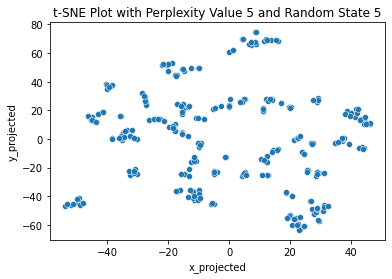

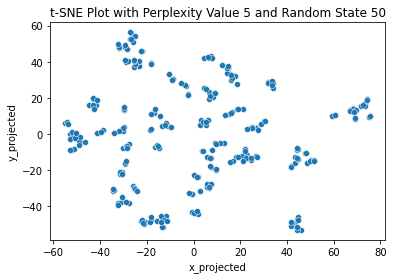

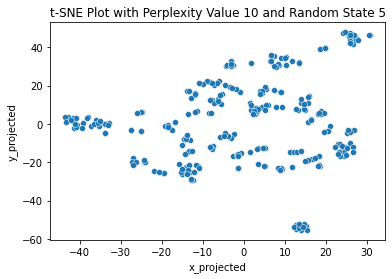

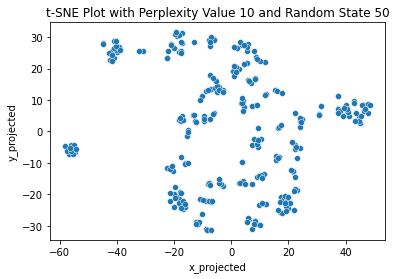

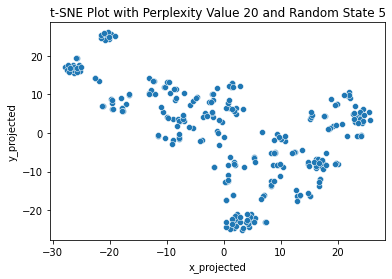

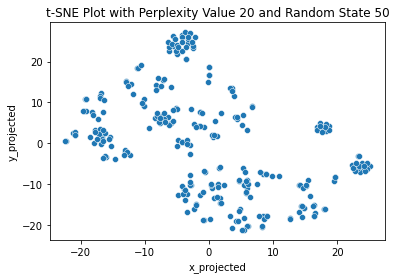

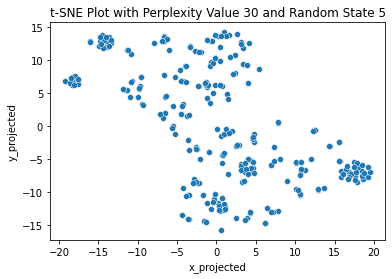

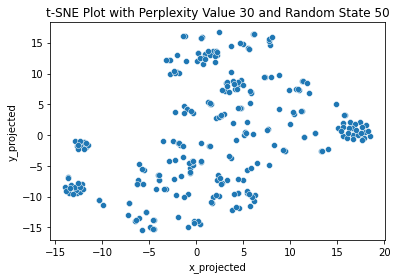

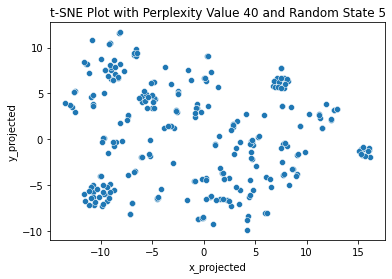

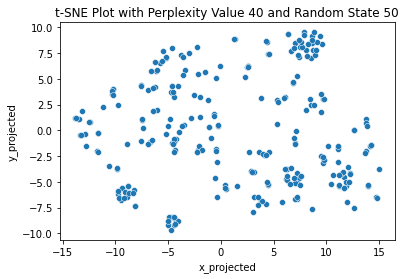

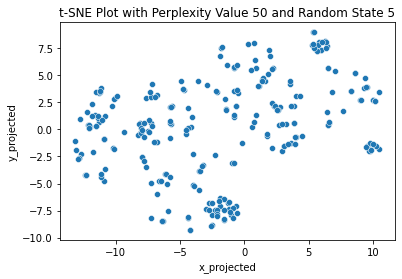

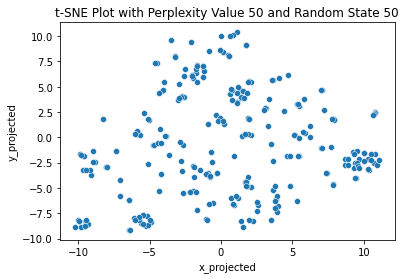

In [38]:
for perp in [5,10, 20, 30, 40, 50]:
    for rs in [5, 50]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed')
        data_tsne = tsne.fit_transform(dist_mat)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([df, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()

### 2.2 Assessing Clustering Structure

Answer the following questions below.

1. Does the t-SNE algorithm suggest that this dataset is clusterable?
2. How many "main clusters" do you think that this dataset has? *[Subjective Answer: As long as your logic is correct, you will not lose points].*
3. Do you think that this dataset has nested clusters (ie. subclusters)? Explain. *[Subjective Answer: As long as your logic is correct, you will not lose points].*

Finally, pick out a random state and perplexity value that reflects the answers to your questions and show the corresponding t-SNE plot below.

1. t-SNE algorithm suggest that the dataset is clusterable. 
2. From the plot of perplexity 20 and state 50 below, it seems the dataset has at least 3 main clusters. 
3. This dataset might have subclusters since the clusters are not well-seperated and there is a lot of overlap between clusters.


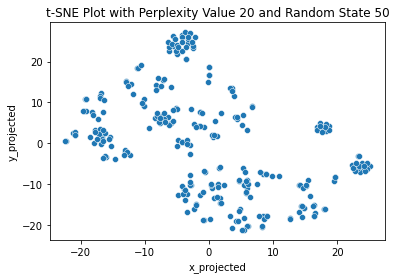

In [39]:
for perp in [20]:
    for rs in [50]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed')
        data_tsne = tsne.fit_transform(dist_mat)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([df, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()

### 2.3. Association between the Attributes and the Clustering Structure Suggested by the t-SNE Plots

Finally, we would like to assess how each of our 17 attributes is individually associated with the clustering structure suggested by our selected t-SNE plot from 2.2. Below, plot your t-SNE plot 17 times, each time color coding the points by each of the 17 attributes.

In [32]:
att = X.columns

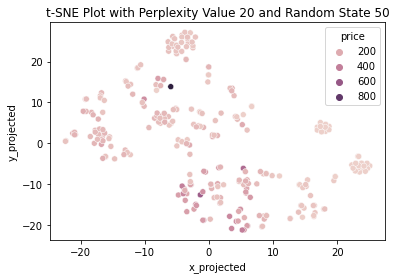

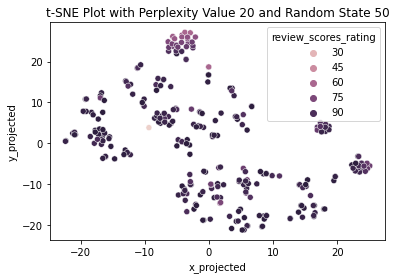

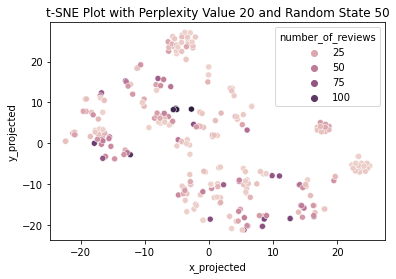

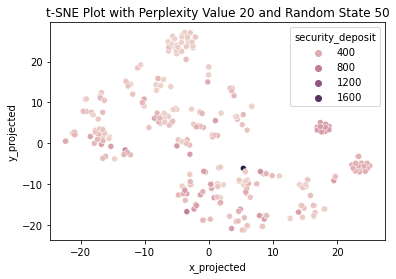

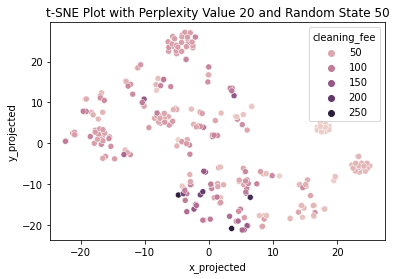

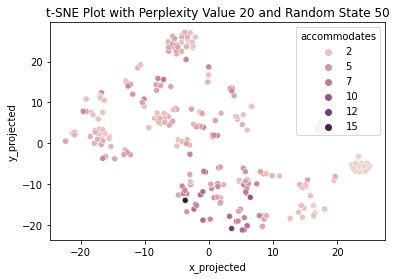

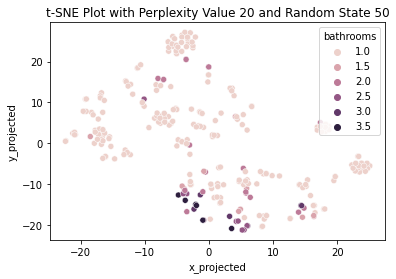

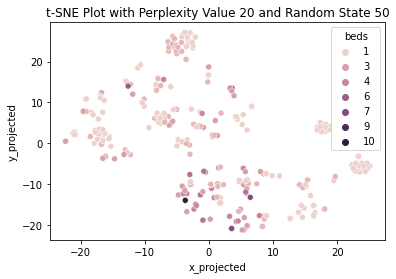

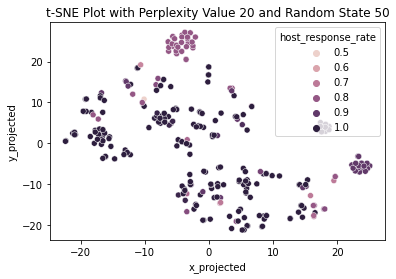

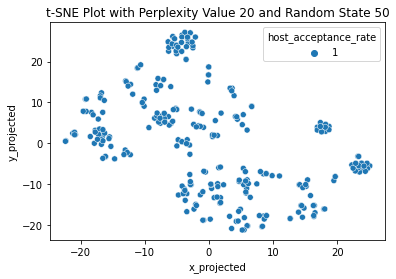

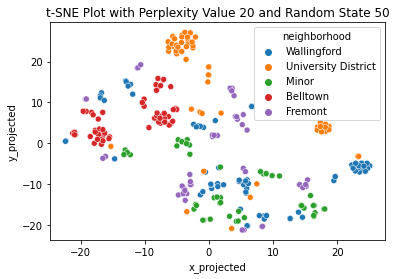

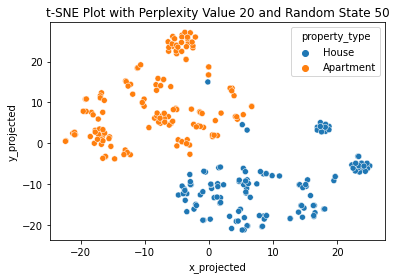

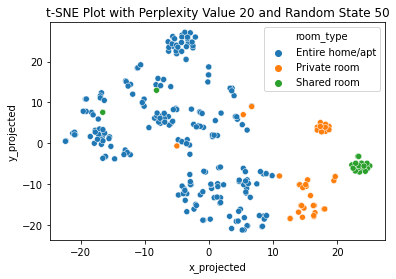

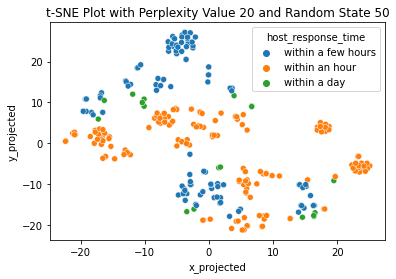

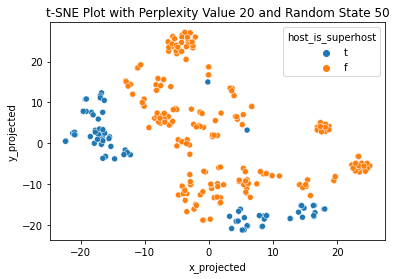

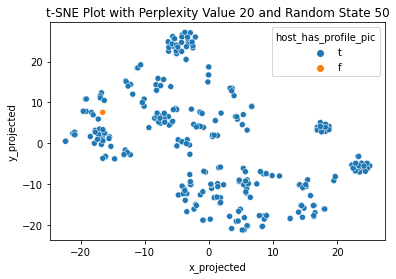

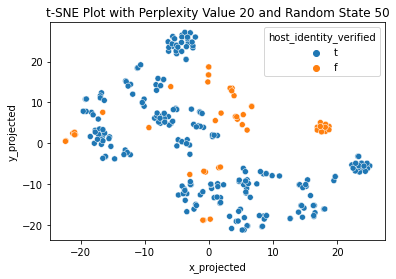

In [37]:
for col in att:
    for perp in [20]:
        for rs in [50]:
            tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed')
            data_tsne = tsne.fit_transform(dist_mat)
            df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
            df_combo = pd.concat([df, df_tsne], axis=1)
            sns.scatterplot(x='x_projected',y='y_projected',hue = col, data=df_combo)
            plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
            plt.show()

## 3. K-Prototypes - *Parameter Selection*

First, we would like to cluster this dataset with the k-prototypes algorithm. We would like to explore what the best values of $k$ and $\gamma$ would be to use in this clustering algorithm to meet our research goals.



### 3.1. $\gamma = 0.25$

#### 3.1.1. Elbow Plot
Create an elbow plot for the k-prototypes algorithm using a value of $\gamma=0.25$. Your plot should assess clusterings with k=1, k=2,..., k=16 clusters. For each k, run a single k-prototypes algorith, using a random state of 100.

In [20]:
cost = []
for num_clusters in list(range(1,17)):
    print(num_clusters)
    kp = KPrototypes(n_clusters=num_clusters,gamma = 0.25, random_state=100)
    fit_cluster = kp.fit_predict(X, categorical=[10,11,12,13,14,15,16])
    cost.append(kp.cost_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


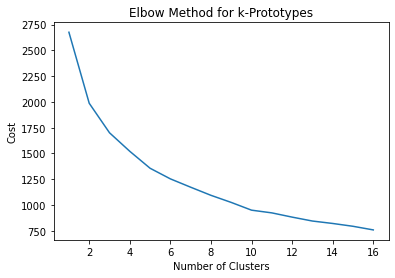

In [21]:
plt.plot(list(range(1,17)),cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for k-Prototypes')
plt.show()

#### 3.1.2. t-SNE Plots

For k=1, k=2,..., k=10, run the k-prototypes clustering algorithm on your dataset, using a value of $\gamma=0.25$ and a random state of 100. For each of your clusterings, plot a t-SNE plot in which you have color coded the points by their cluster labels.

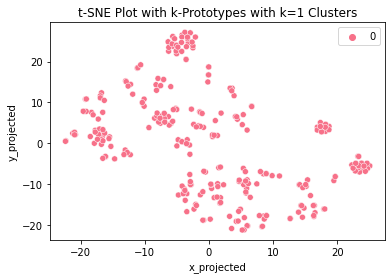

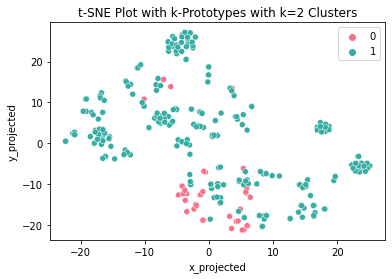

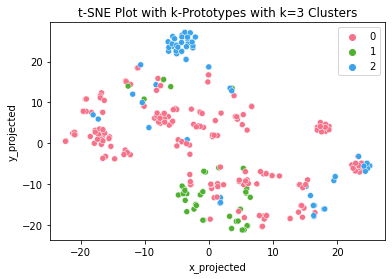

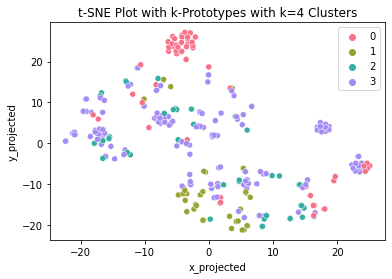

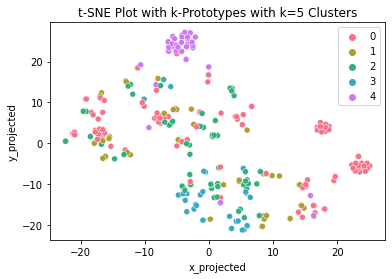

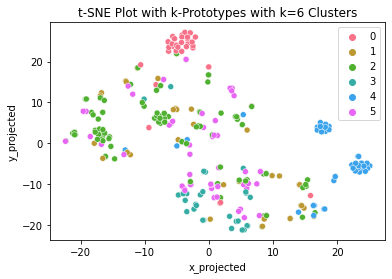

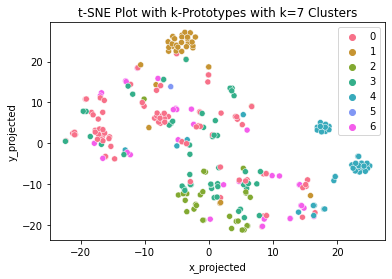

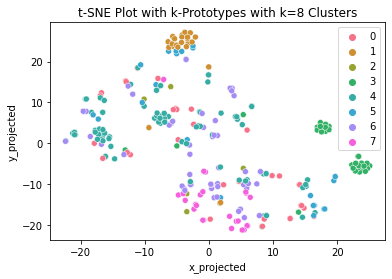

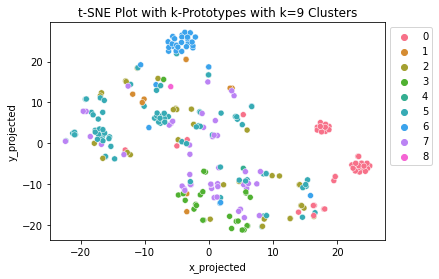

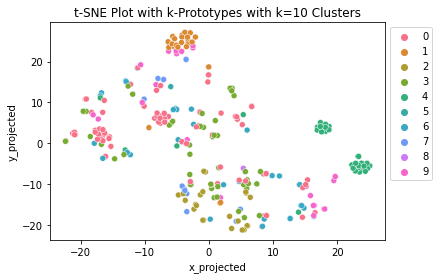

In [36]:
for num_clusters in list(range(1,11)):
    kp = KPrototypes(n_clusters = num_clusters, gamma = 0.25, random_state = 100)
    fit_cluster = kp.fit_predict(X, categorical=[10,11,12,13,14,15,16])
    
    df_combo['predicted_cluster']=fit_cluster
    
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", num_clusters), data=df_combo)
    plt.title('t-SNE Plot with k-Prototypes with k=%s Clusters' %(num_clusters))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 3.2. $\gamma = 0.5$ 

#### 3.2.1. Elbow Plot
Create an elbow plot for the k-prototypes algorithm using a value of $\gamma=0.5$. Your plot should assess clusterings with k=1, k=2,..., k=16 clusters. For each k, run a single k-prototypes algorith, using a random state of 100.

In [23]:
cost = []
for num_clusters in list(range(1,17)):
    print(num_clusters)
    kp = KPrototypes(n_clusters=num_clusters,gamma = 0.5, random_state=100)
    kp.fit_predict(X, categorical=[10,11,12,13,14,15,16])
    cost.append(kp.cost_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


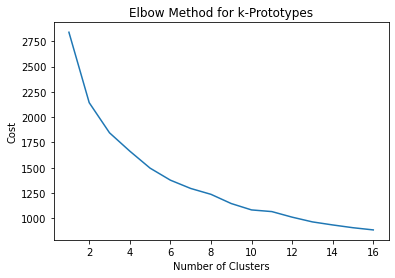

In [24]:
plt.plot(list(range(1,17)),cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for k-Prototypes')
plt.show()

#### 3.1.2. t-SNE Plots

For k=1, k=2,..., k=10, run the k-prototypes clustering algorithm on your dataset, using a value of $\gamma=0.5$ and a random state of 100. For each of your clusterings, plot a t-SNE plot in which you have color coded the points by their cluster labels.

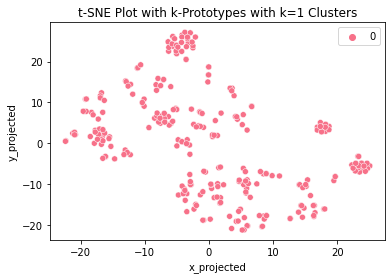

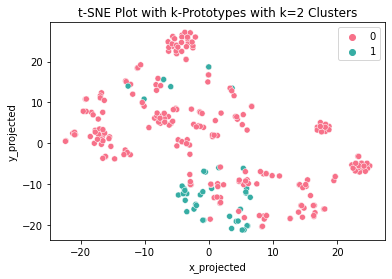

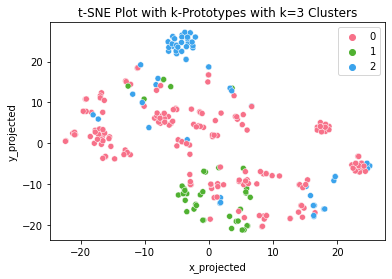

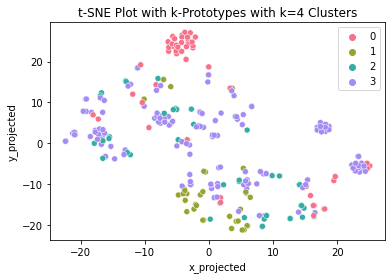

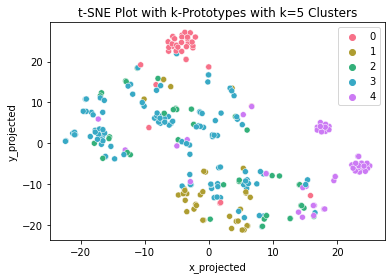

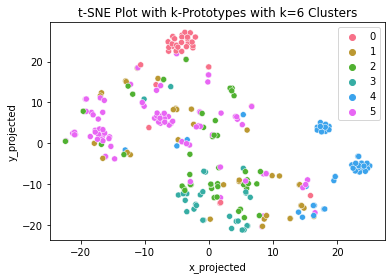

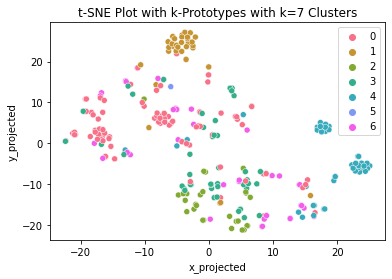

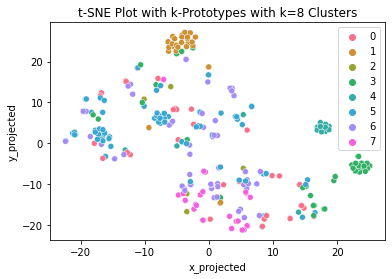

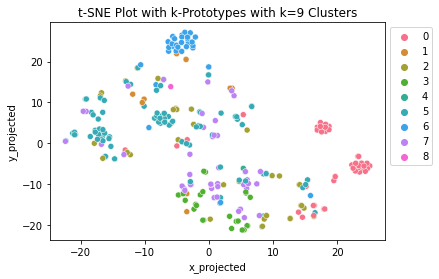

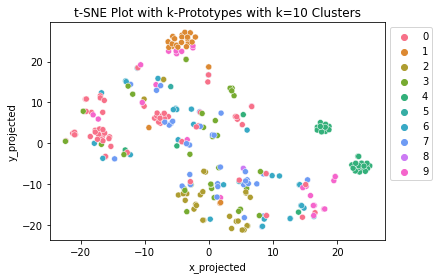

In [40]:
for num_clusters in list(range(1,11)):
    kp = KPrototypes(n_clusters = num_clusters, gamma = 0.5, random_state = 100)
    fit_cluster = kp.fit_predict(X, categorical=[10,11,12,13,14,15,16])
    
    df_combo['predicted_cluster']=fit_cluster
    
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", num_clusters), data=df_combo)
    plt.title('t-SNE Plot with k-Prototypes with k=%s Clusters' %(num_clusters))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 3.3. $\gamma = 100$ 

#### 3.3.1. Elbow Plot
Create an elbow plot for the k-prototypes algorithm using a value of $\gamma=100$. Your plot should assess clusterings with k=1, k=2,..., k=16 clusters. For each k, run a single k-prototypes algorith, using a random state of 100.

In [ ]:
cost = []
for num_clusters in list(range(1,17)):
    print(num_clusters)
    kp = KPrototypes(n_clusters=num_clusters,gamma = 100, random_state=100)
    kp.fit_predict(X, categorical=[10,11,12,13,14,15,16])
    cost.append(kp.cost_)

1
2
3
4
5
6
7
8
9


In [ ]:
plt.plot(list(range(1,17)),cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for k-Prototypes')
plt.show()

#### 3.1.3. t-SNE Plots

For k=1, k=2,..., k=10, run the k-prototypes clustering algorithm on your dataset, using a value of $\gamma=100$ and a random state of 100. For each of your clusterings, plot a t-SNE plot in which you have color coded the points by their cluster labels.

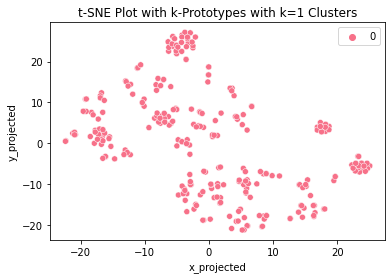

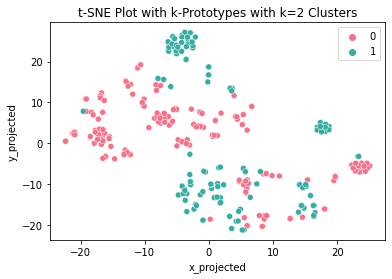

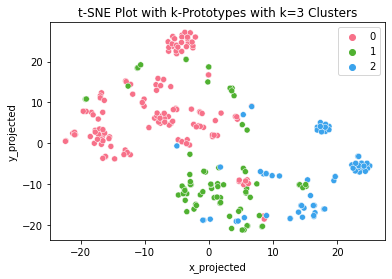

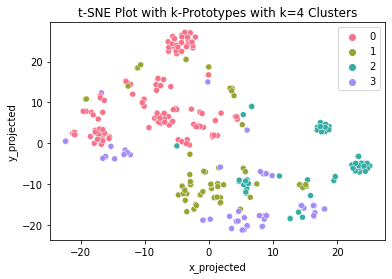

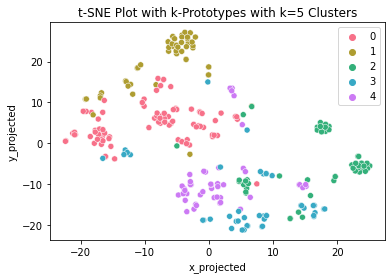

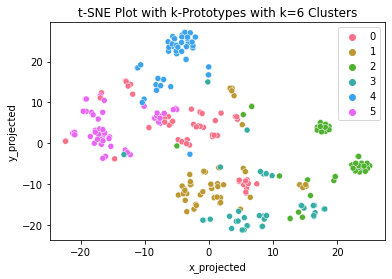

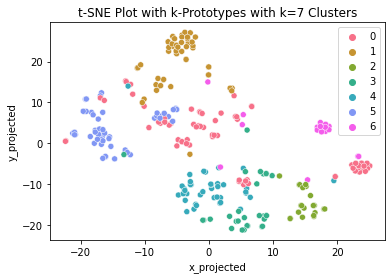

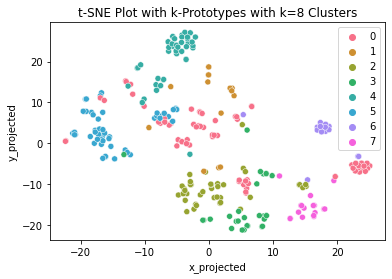

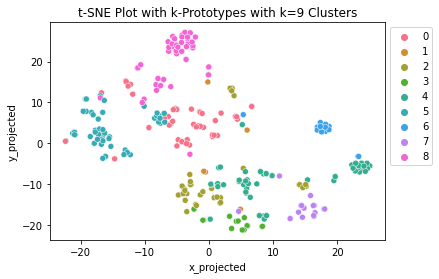

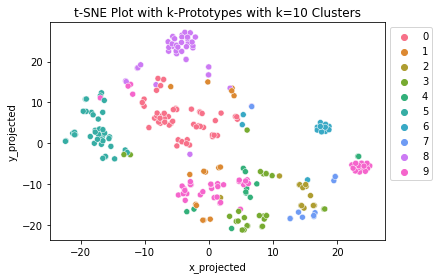

In [41]:
for num_clusters in list(range(1,11)):
    kp = KPrototypes(n_clusters = num_clusters,gamma = 100, random_state = 100)
    fit_cluster = kp.fit_predict(X, categorical=[10,11,12,13,14,15,16])
    
    df_combo['predicted_cluster']=fit_cluster
    
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", num_clusters), data=df_combo)
    plt.title('t-SNE Plot with k-Prototypes with k=%s Clusters' %(num_clusters))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 3.4. Interpretation

#### 3.4.1. Elbow Plots

Do we think that any of the values of gamma used above (ie. $\gamma \in \{0.25, 0.5, 100\}$) in the k-prototypes algorithm will be able to identify a *strong* clustering relationship in the dataset? Explain.


There isn't signs of a strong elbow for gamma of 0.25, 0.5, or 100, so the k-prototypes algorithm will not be able to identify a strong clustering relationship in the dataset.

#### 3.4.2. $\gamma$ Interpretation

Which value of $\gamma \in \{0.25, 0.5, 100\}$  will the numerical variables have the strongest influence on the results of the k-prototypes algorithm? Which value of $\gamma \in \{0.25, 0.5, 100\}$  will the categorical variables have the strongest influence on the results of the k-prototypes algorithm?


Gamma of 100 will let the categorical and numerical variables have the strongest influence on the results of the k-prototypes algorithm.

#### 3.4.3. Result that is most consistent with t-SNE plots

Which value of $\gamma \in \{0.25, 0.5, 100\}$ produced k-prototypes clustering results that were most consistent with the clustering structure suggested by the t-SNE plots?


Gamma of 100 produced k-prototypes clustering results that were most consistent with the clustering structure suggested by the t-SNE plots.

#### 3.4.4. t-SNE Plot with Gower's Distance

Using what we know so far, do we think that the clustering structure that is suggested by this particular t-SNE plot happens to be more dominated by the categorical variables, the numerical variables, or are the numerical and categorical variables equally represented? Explain.


The clustering structure seems to be more dominated by the categorical variables because gamma has an extreme value of 100, which gives more weight to categorical variables more in clustering.


<hr>

### 3.5. Post Cluster Analysis with k-Prototypes and k=4 Clusters and $\gamma =100$.

#### 3.5.1. Cluster the Dataset

Finally, cluster the dataset one more time with k-Prototypes using k=4 Clusters and $\gamma =100$.

In [48]:
kp = KPrototypes(n_clusters = 4,gamma = 100, random_state=100)
fit_clusters = kp.fit_predict(X, categorical 
                             = [10,11,12,13,14,15,16])
df_combo['predicted_cluster']=fit_clusters

#### 3.5.2. Prototypes

Next, display the four cluster prototypes. The numerical values in your prototypes that you display should be **unscaled**. Put your four prototypes all into the same dataframe.

In [49]:
att = ['price','review_scores_rating','number_of_reviews','security_deposit','cleaning_fee','accommodates','bathrooms','beds','host_response_rate','host_acceptance_rate']

In [50]:
kp.cluster_centroids_

array([['-0.06973989427039205', '-0.1647635126493462',
        '0.004794806469700098', '-0.3444806726975019',
        '-0.09348571910901765', '-0.21117039563771686',
        '-0.32151267275058854', '-0.30771113541767686',
        '-0.10958054475793678', '0.0', 'Belltown', 'Apartment',
        'Entire home/apt', 'within an hour', 'f', 't', 't'],
       ['0.5116437728539359', '-0.09443573306098822',
        '-0.21933833775261086', '0.27501960719526986',
        '0.689856371231566', '0.7086959101518221', '0.43720234450206885',
        '0.7970743316599243', '0.03756617827399574', '0.0', 'Fremont',
        'House', 'Entire home/apt', 'within a few hours', 'f', 't', 't'],
       ['-0.6588087964010476', '-0.04678431349891166',
        '-0.2896983575815001', '0.46765091016065746',
        '-0.6977284998511653', '-0.6344827635294055',
        '-0.24193768083556721', '-0.4375189944707759',
        '-0.011914766413944624', '0.0', 'Wallingford', 'House',
        'Private room', 'within an hour', '

In [67]:
df_prototype=pd.DataFrame(kp.cluster_centroids_, columns = X.columns)
num = df_prototype[att]
num = num.astype('float')

unscaled=pd.DataFrame(scaler.inverse_transform(num))
unscaled.columns = att
df_prototype[att] = unscaled[att]
df_prototype

price  review_scores_rating  number_of_reviews  security_deposit  \
0  127.305085             91.627119          22.576271        202.355932   
1  181.533333             92.266667          16.916667        305.750000   
2   72.360000             92.700000          15.140000        337.900000   
3  152.960784             98.019608          35.862745        262.352941   

   cleaning_fee  accommodates  bathrooms      beds  host_response_rate  \
0     59.161017      3.220339   1.055085  1.525424            0.934915   
1     89.316667      5.133333   1.483333  2.933333            0.948000   
2     35.900000      2.340000   1.100000  1.360000            0.943600   
3     66.176471      4.235294   1.500000  2.176471            0.964314   

   host_acceptance_rate neighborhood property_type        room_type  \
0                   1.0     Belltown     Apartment  Entire home/apt   
1                   1.0      Fremont         House  Entire home/apt   
2                   1.0  Wallingford         House     Private room   
3                   1.0        Minor         House  Entire home/apt   

   host_response_time host_is_superhost host_has_profile_pic  \
0      within an hour                 f                    t   
1  within a few hours                 f                    t   
2      within an hour                 f                    t   
3      within an hour                 t                    t   

  host_identity_verified  
0                      t  
1                      t  
2                      t  
3                      t

#### 3.5.3. Interpretation

What type of categorical attribute values are most common in the cluster with the highest average listing price?

*(Note: In a full analysis you would want to describe and compare every prototype to learn more about the cluster attributes)*.

Neighborhood, property_type, room_type, host_response_time, host_is_superhost, and host_has_profile_pic are the most common attribute values.

## 4. Hierarchical Agglomerative Clustering

Next, we would like to cluster our Gower's distance matrix with hierarchical agglomerative clustering using single linkage, complete linkage, and average linkage.



### 4.1. Single Linkage

#### 4.1.1. Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with single linkage for using your Gower's distance matrix. 
* Because this is a small dataset, we do not need/want to truncate our dendrogram results. You should be able to see the indices of each of your observations at the leaves of your dendrogram tree.
* Make sure you are able to read the indices labels in your dendrogram.

In [68]:
dist_mat=gower_matrix(X)
dist_mat

array([[0.        , 0.21944802, 0.2697147 , ..., 0.2891037 , 0.14629324,
        0.22592035],
       [0.21944802, 0.        , 0.07534599, ..., 0.07739875, 0.21911365,
        0.13737465],
       [0.2697147 , 0.07534599, 0.        , ..., 0.11949195, 0.2724411 ,
        0.18402632],
       ...,
       [0.2891037 , 0.07739875, 0.11949195, ..., 0.        , 0.17406343,
        0.08196895],
       [0.14629324, 0.21911365, 0.2724411 , ..., 0.17406343, 0.        ,
        0.11578206],
       [0.22592035, 0.13737465, 0.18402632, ..., 0.08196895, 0.11578206,
        0.        ]], dtype=float32)

In [69]:
dm=squareform(dist_mat, force = 'tovector')
dm

array([0.21944802, 0.2697147 , 0.12338875, ..., 0.17406343, 0.08196895,
       0.11578206], dtype=float32)

In [70]:
Z = linkage(dm, method='single')
Z

array([[2.03000000e+02, 2.29000000e+02, 0.00000000e+00, 2.00000000e+00],
       [2.00000000e+01, 2.70000000e+01, 0.00000000e+00, 2.00000000e+00],
       [2.20000000e+01, 4.70000000e+01, 0.00000000e+00, 2.00000000e+00],
       ...,
       [9.50000000e+01, 5.53000000e+02, 1.40930623e-01, 2.77000000e+02],
       [1.23000000e+02, 5.54000000e+02, 1.46989927e-01, 2.78000000e+02],
       [2.30000000e+02, 5.55000000e+02, 1.89387873e-01, 2.79000000e+02]])

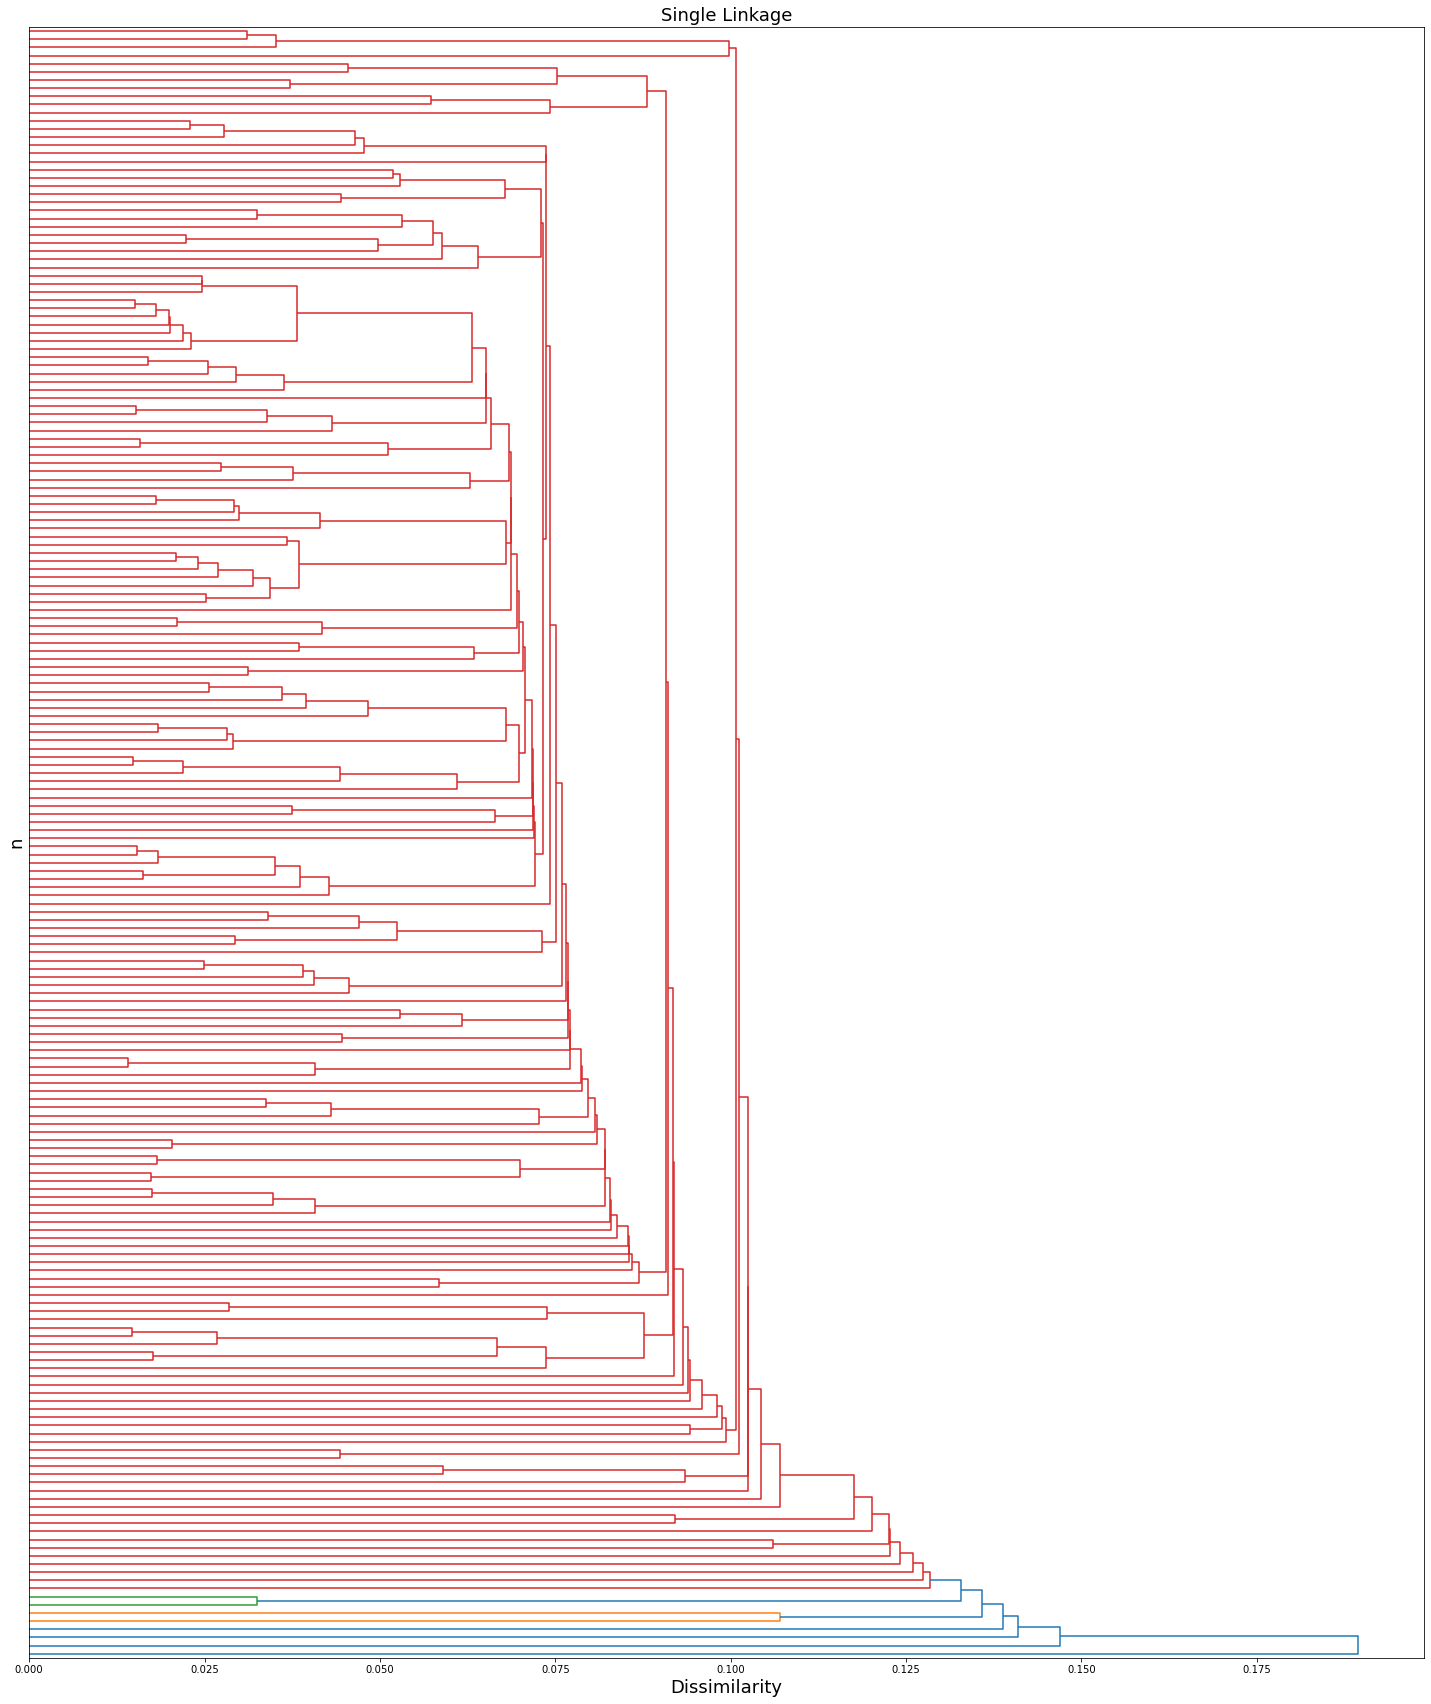

In [71]:
fig, ax = plt.subplots(figsize=(25, 30))
d = dendrogram(Z, orientation='right', ax=ax, truncate_mode='lastp', p=200, no_labels=True)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('n', fontsize=18)
plt.yticks(fontsize=12)
plt.title('Single Linkage', fontsize=18)
plt.show()

#### 4.1.2 [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=10 clusters, color code the points in your selected t-SNE plot with the respective cluster labels.

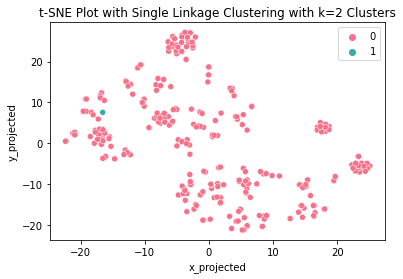

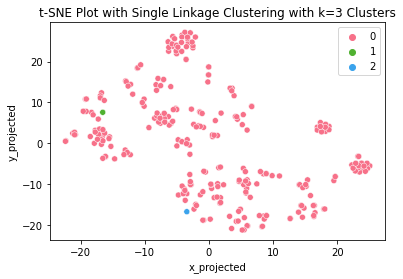

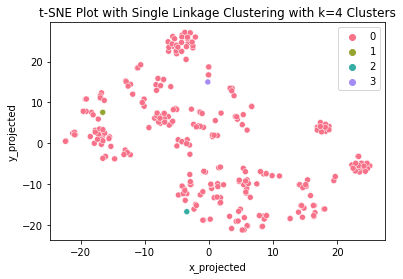

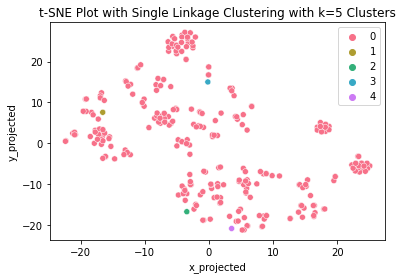

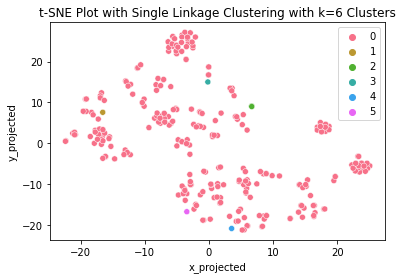

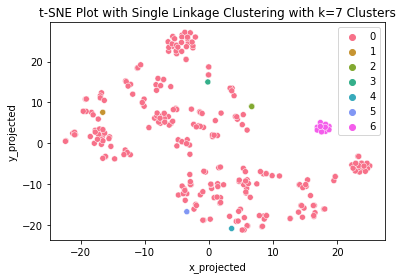

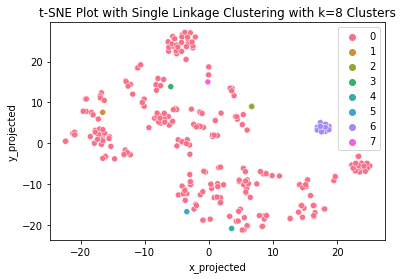

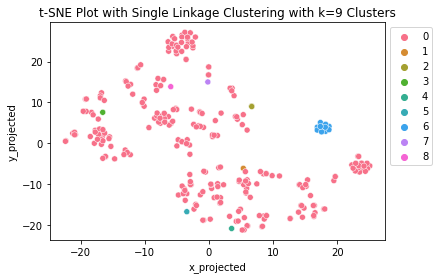

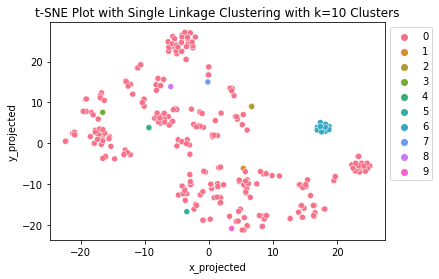

In [72]:
for k in range(2,11):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='single')
    df_combo['predicted_cluster'] = hac.fit_predict(dist_mat)
    
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Single Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 4.2. Complete Linkage

#### 4.2.1. Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with complete linkage using your Gower's distance matrix.
* Because this is a small dataset, we do not need/want to truncate our dendrogram results. You should be able to see the indices of each of your observations at the leaves of your dendrogram tree.
* Make sure you are able to read the indices labels in your dendrogram.

In [73]:
Z = linkage(dm, method='complete')
Z

array([[2.03000000e+02, 2.29000000e+02, 0.00000000e+00, 2.00000000e+00],
       [2.00000000e+01, 2.70000000e+01, 0.00000000e+00, 2.00000000e+00],
       [2.20000000e+01, 4.70000000e+01, 0.00000000e+00, 2.00000000e+00],
       ...,
       [5.43000000e+02, 5.51000000e+02, 4.72165078e-01, 1.09000000e+02],
       [5.47000000e+02, 5.54000000e+02, 5.00330627e-01, 1.32000000e+02],
       [5.53000000e+02, 5.55000000e+02, 5.80589056e-01, 2.79000000e+02]])

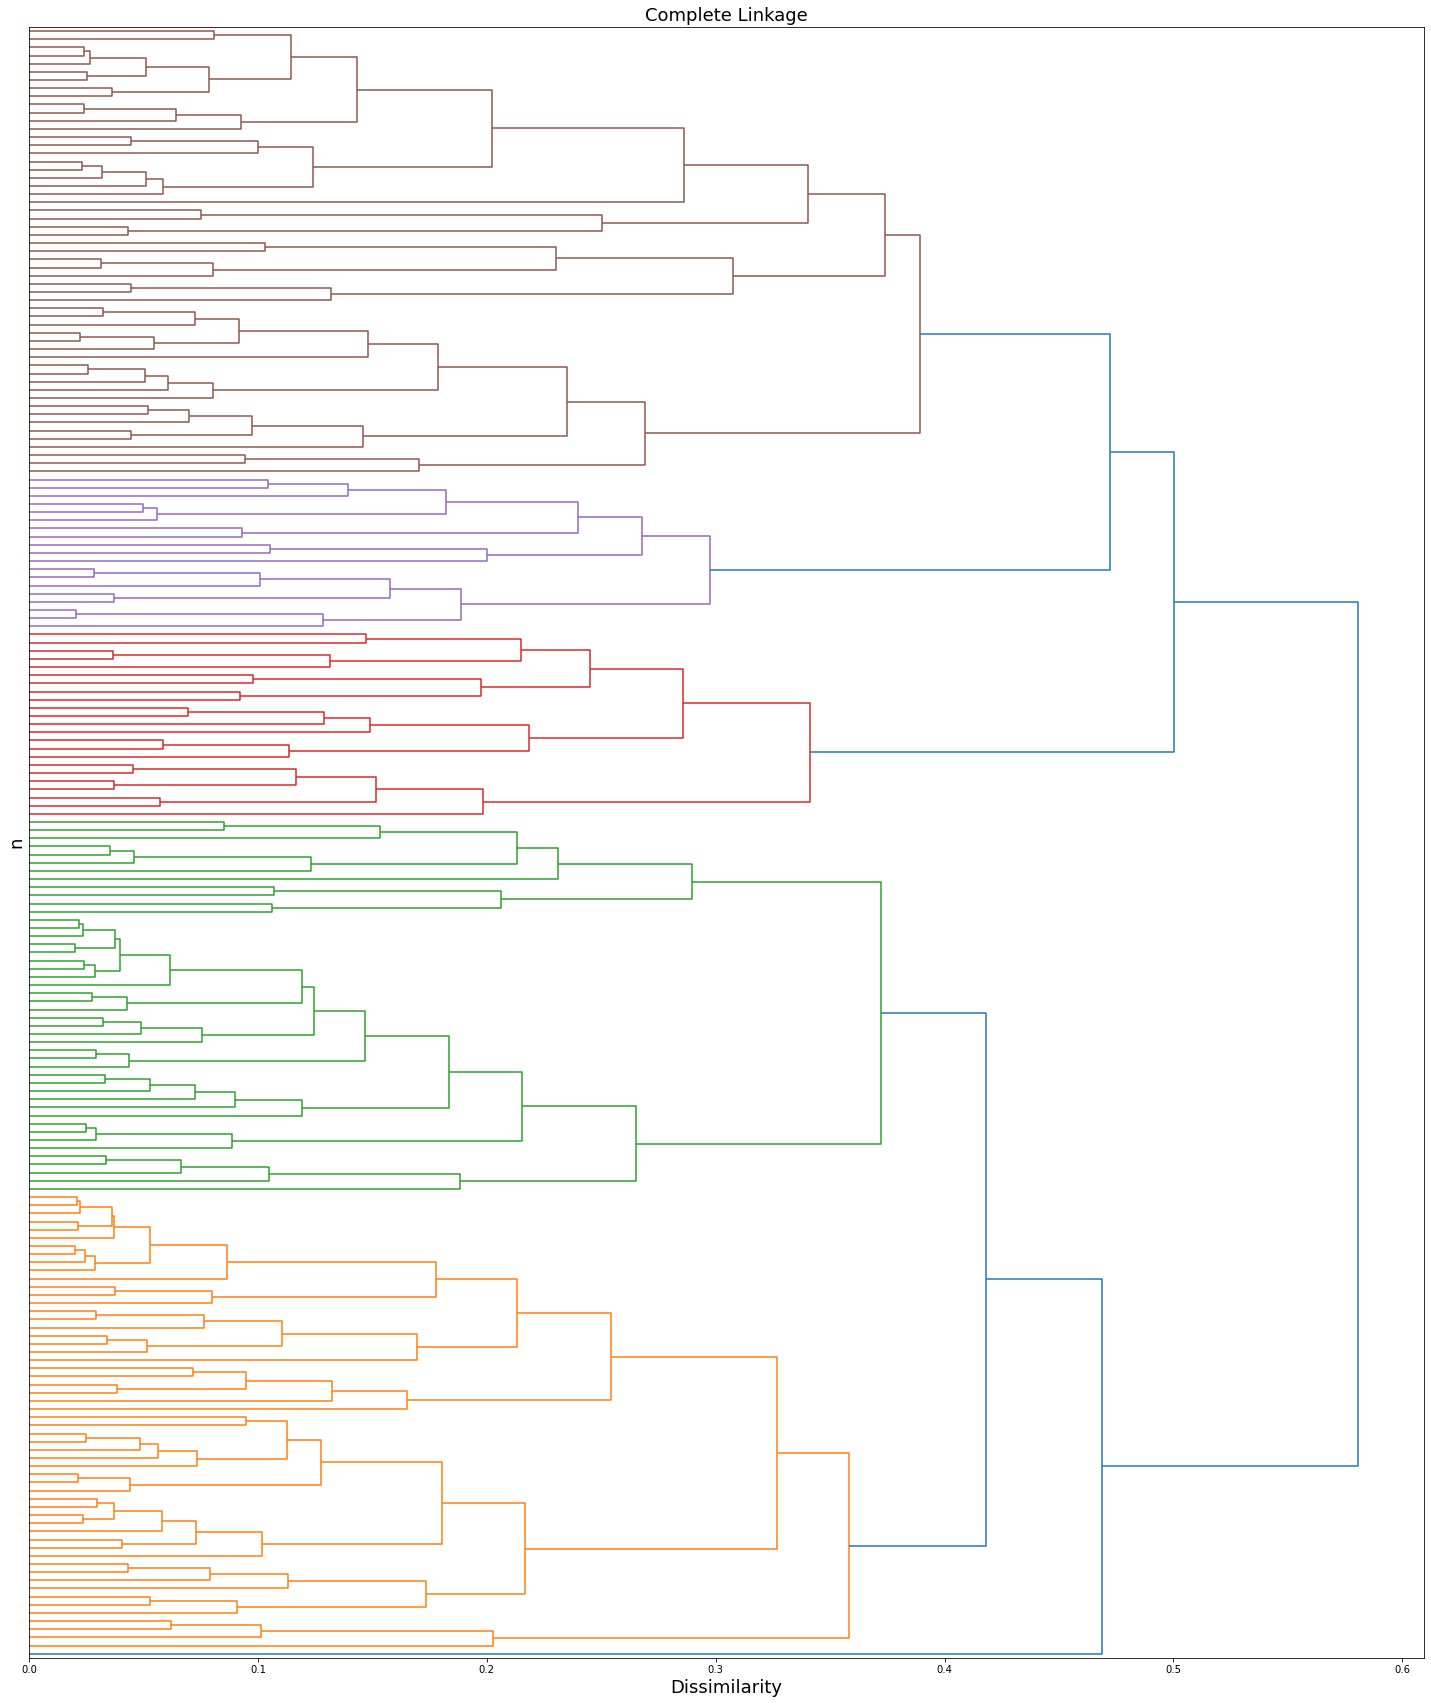

In [74]:
fig, ax = plt.subplots(figsize=(25, 30))
d = dendrogram(Z, orientation='right', ax=ax, truncate_mode='lastp', p=200, no_labels=True)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('n', fontsize=18)
plt.yticks(fontsize=12)
plt.title('Complete Linkage', fontsize=18)
plt.show()

#### 4.2.2 [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=10 clusters, color code the points in your selected t-SNE plot with the respective cluster labels.

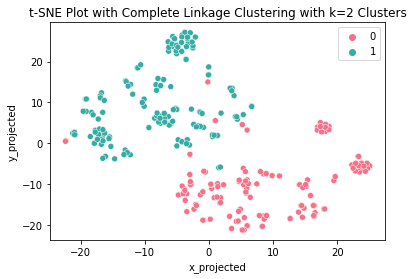

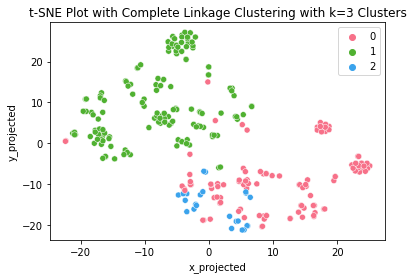

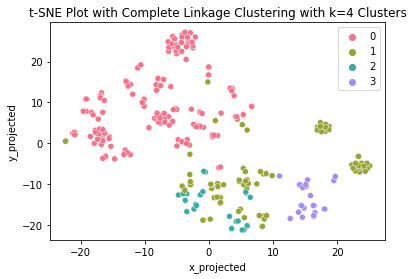

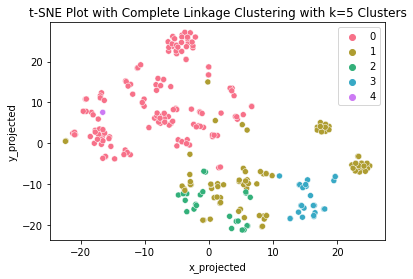

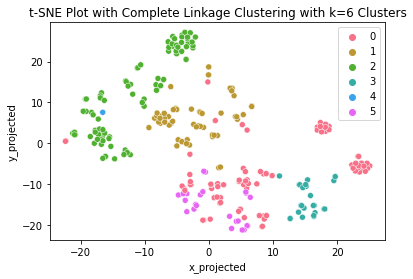

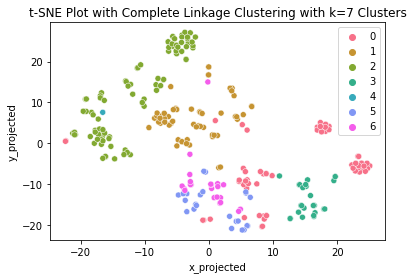

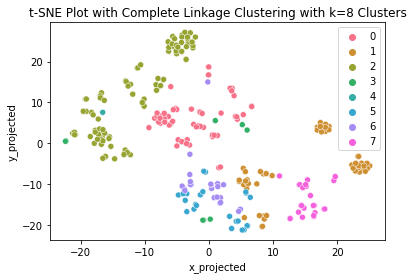

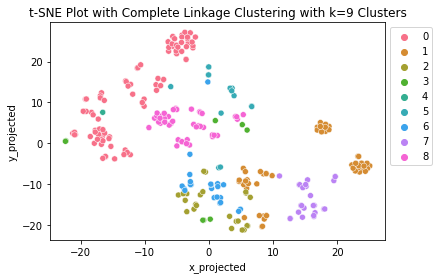

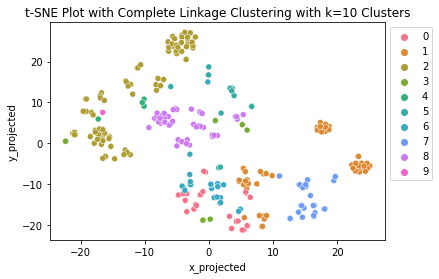

In [75]:
for k in range(2,11):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='complete')
    df_combo['predicted_cluster'] = hac.fit_predict(dist_mat)
    
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Complete Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 4.3. Average Linkage

#### 4.3.1. Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with average linkage using your Gower's distance matrix.
* Because this is a small dataset, we do not need/want to truncate our dendrogram results. You should be able to see the indices of each of your observations at the leaves of your dendrogram tree.
* Make sure you are able to read the indices labels in your dendrogram.

In [76]:
Z = linkage(dm, method='average')
Z

array([[2.00000000e+01, 2.70000000e+01, 0.00000000e+00, 2.00000000e+00],
       [2.20000000e+01, 4.70000000e+01, 0.00000000e+00, 2.00000000e+00],
       [2.03000000e+02, 2.29000000e+02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [5.41000000e+02, 5.53000000e+02, 2.94665750e-01, 2.76000000e+02],
       [5.20000000e+02, 5.54000000e+02, 3.39534913e-01, 2.78000000e+02],
       [2.30000000e+02, 5.55000000e+02, 3.70984413e-01, 2.79000000e+02]])

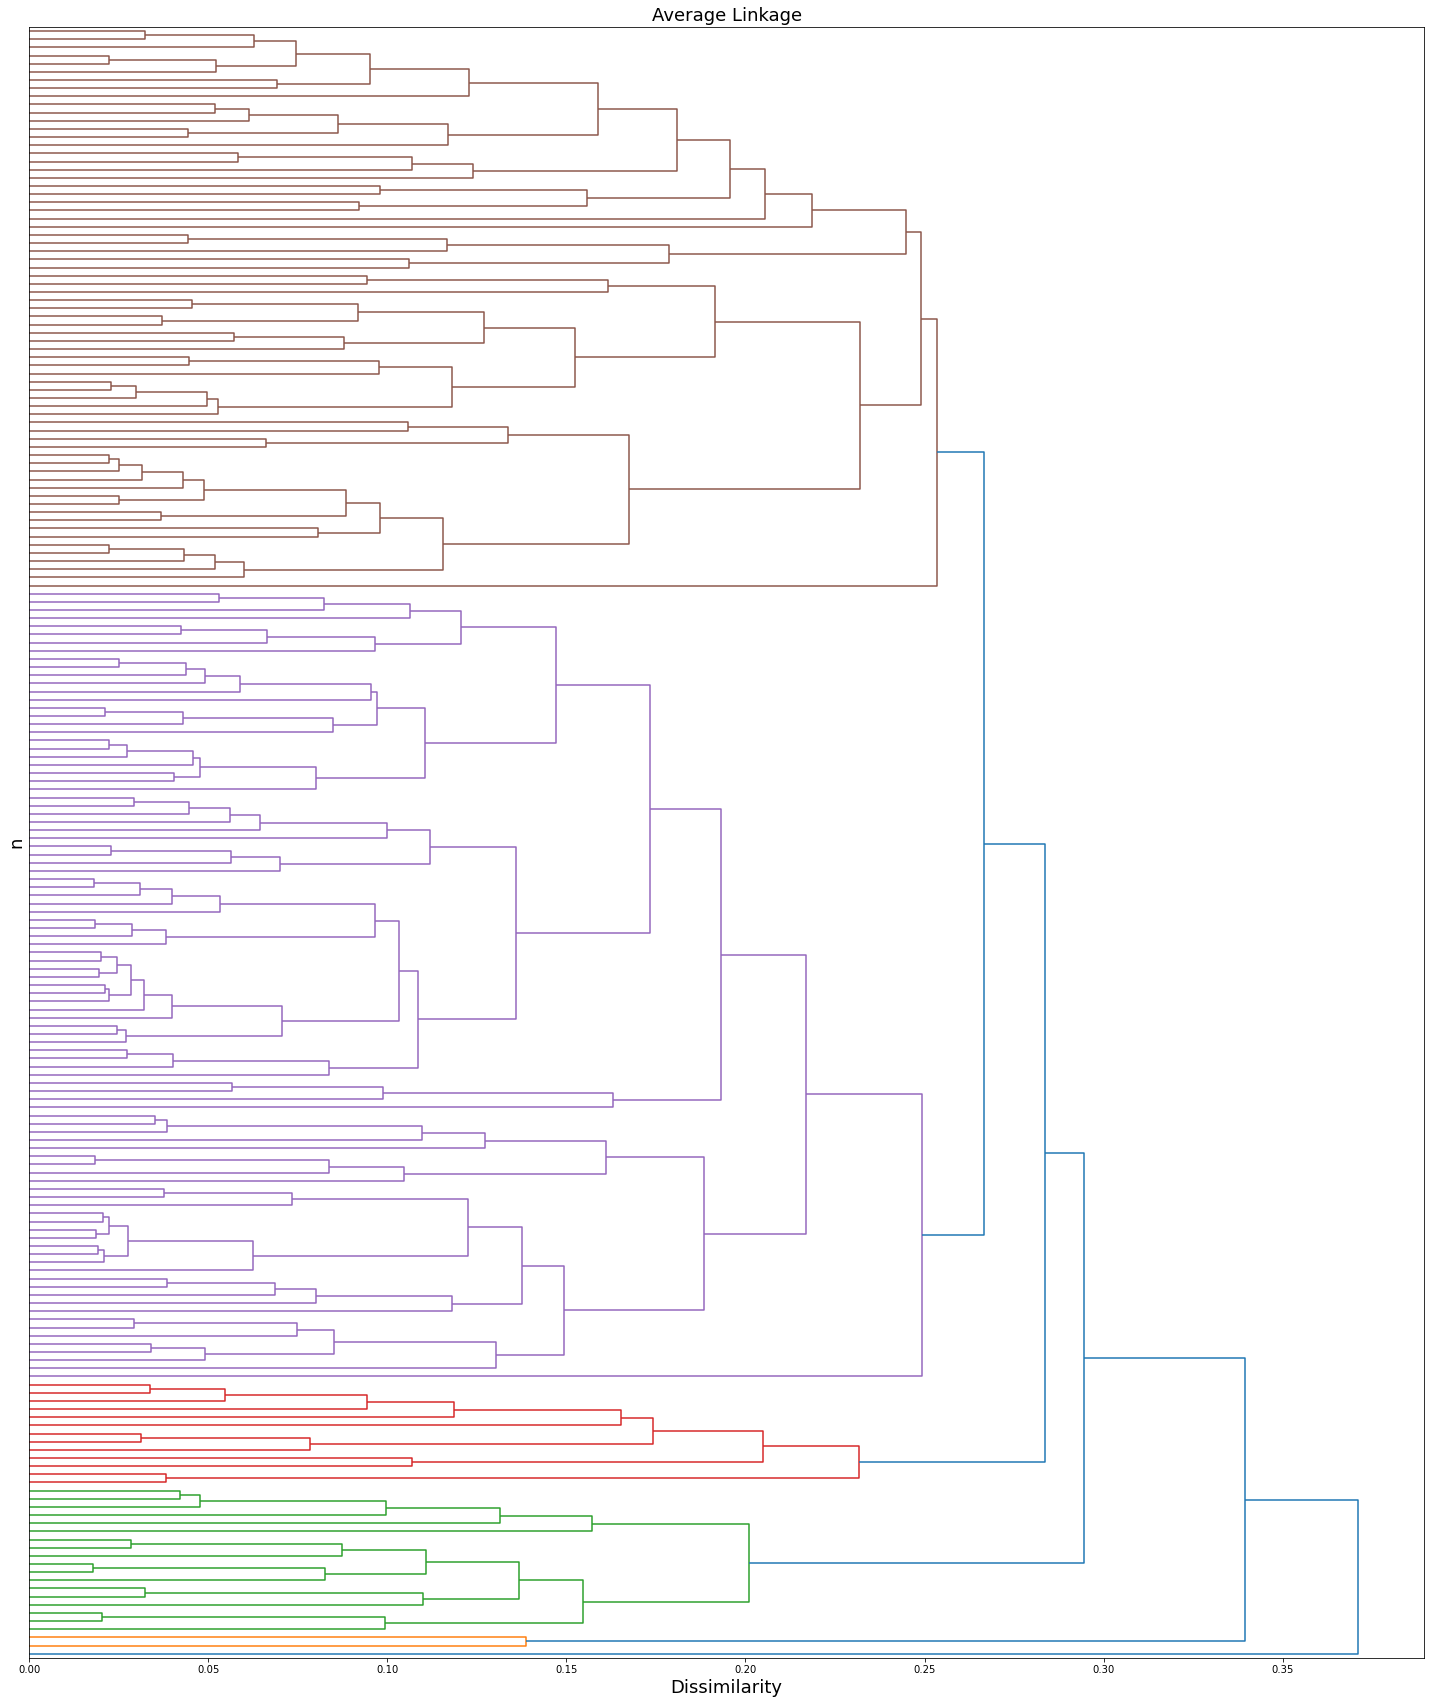

In [77]:
fig, ax = plt.subplots(figsize=(25, 30))
d = dendrogram(Z, orientation='right', ax=ax, truncate_mode='lastp', p=200, no_labels=True)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('n', fontsize=18)
plt.yticks(fontsize=12)
plt.title('Average Linkage', fontsize=18)
plt.show()

#### 4.2.2 [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=10 clusters, color code the points in your selected t-SNE plot with the respective cluster labels.

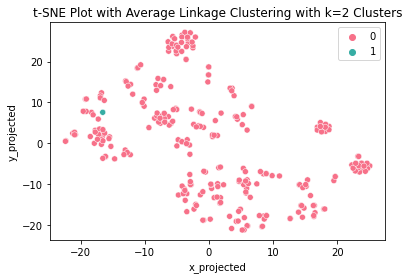

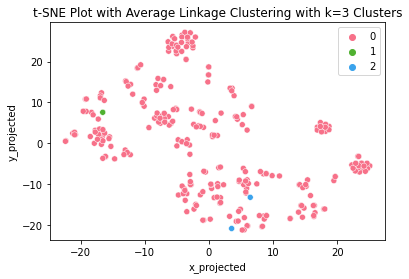

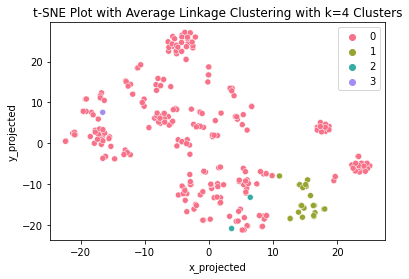

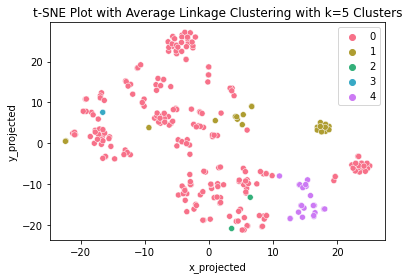

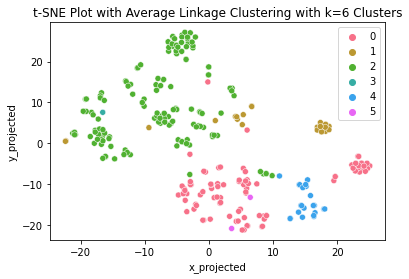

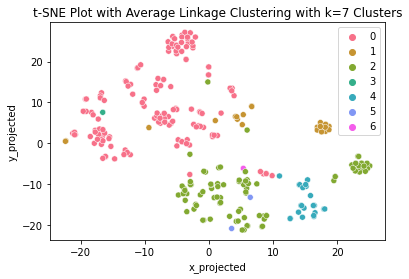

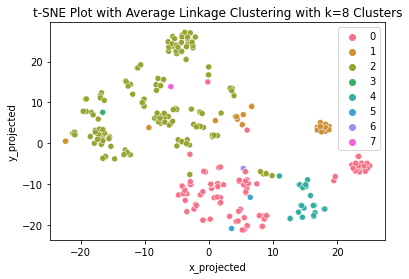

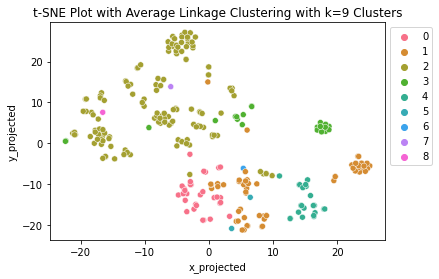

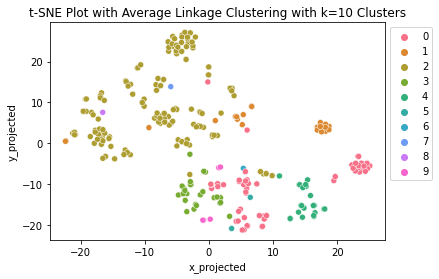

In [78]:
for k in range(2,11):
    #Clustering from dendrogram with k clusters
    hac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='average')
    df_combo['predicted_cluster'] = hac.fit_predict(dist_mat)
    
    #Map the resulting cluster labels onto our chosen t-SNE plot
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Average Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 4.4. Interpretation

The goal of our cluster analysis in this example is to do the following.
1. Identify the "main clusters" that are actually present in this dataset.
2. Identify the nested nature of the clusters in this dataset.
3. To have most of our observations placed in a larger "main cluster" rather than being placed in a small/singleton clusters.

Given the goals of this cluster analysis, which of the following linkage functions do we think best met this goal: single linkage, complete linkage, or average linkage? Explain.


I think the complete linkage with k = 3 clusters best met this goal, because single linkage are mostly influenced by "outliers" and average linkage, although is not influenced too much by outliers, still has the same problem as single linkage.

## 5. Complete Linkage Post-Cluster Analysis

We will choose to examine the clusterings with k=2 and k=3 returned by the hierarchical agglomerative clustering algorithm with complete linkage. 

### 5.1. Clustering with k=2 Clusters


#### 5.1.1. Cluster Characterization

The k=2 clusters in this dataset are the two most distinct groups of listings in the dataset (using the complete linkage function to measure cluster distance).

What attributes had a strong association with the k=2 cluster labels? What attribute values characterize these two most distinct clusters in this dataset? You should examine both the numerical and categorical attributes here. For the numerical attributes, make sure that you look at the **unscaled data**.

For categorical variables, property type, room type, and neighborhood characterizes these 2 clusters. For numerical variables, price, cleaning_fee, and number_of_bathrooms characterizes these 2 clusters.

In [80]:
df_combo = df.copy()
hac = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='complete')
df_combo['predicted_cluster'] = hac.fit_predict(dist_mat)

Let's first examine the numerial attributes for the clustering with k=2 clusters.

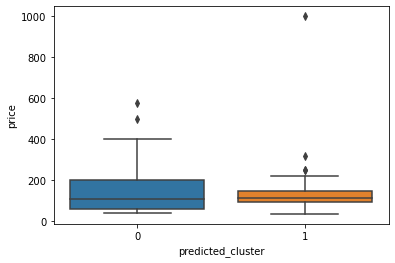

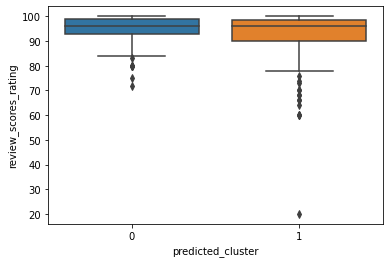

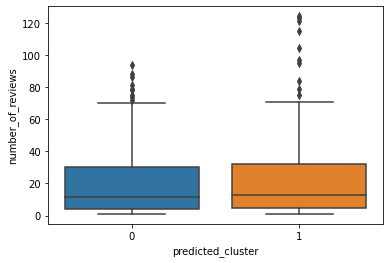

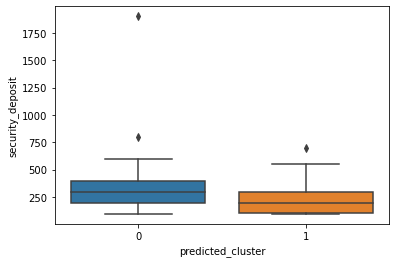

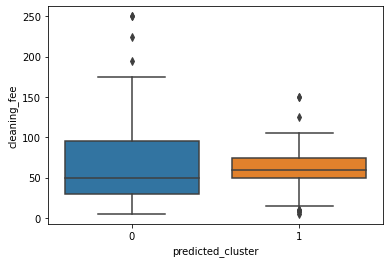

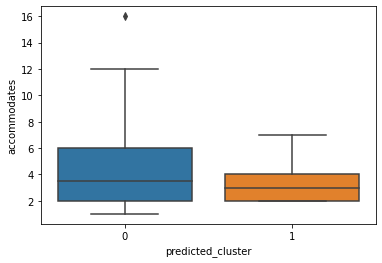

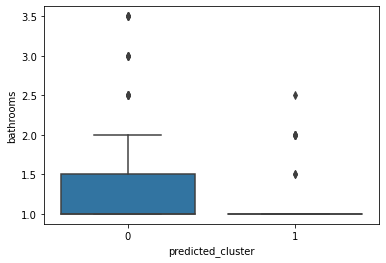

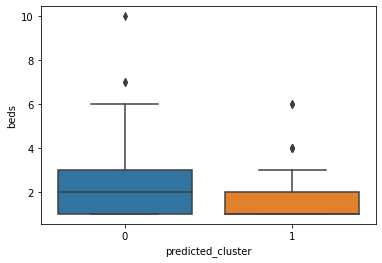

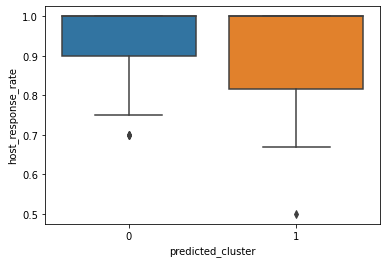

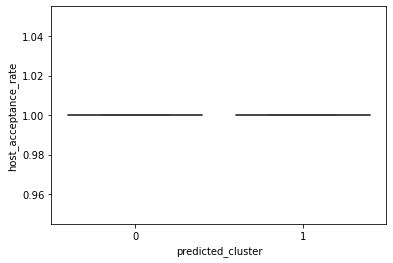

In [89]:
num_att = ['price','review_scores_rating','number_of_reviews','security_deposit','cleaning_fee','accommodates','bathrooms','beds','host_response_rate','host_acceptance_rate']
for col in num_att:
    sns.boxplot(x="predicted_cluster", y=col, data=X)
    plt.show()

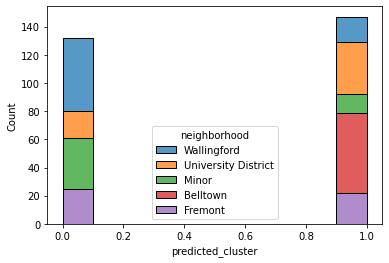

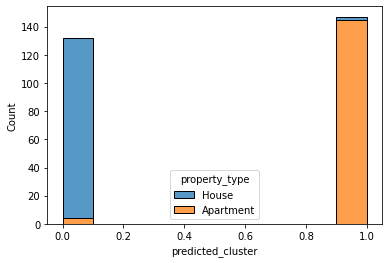

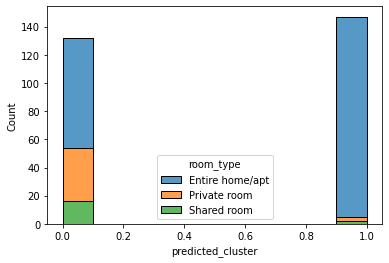

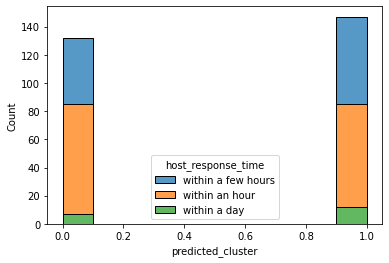

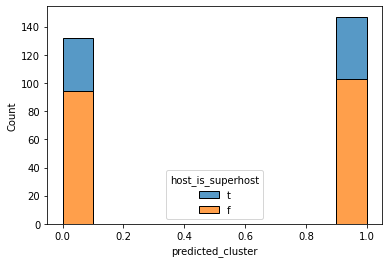

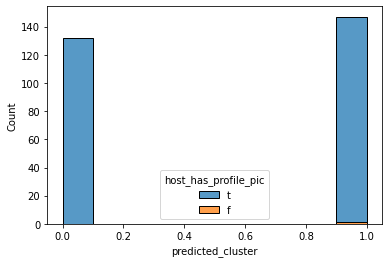

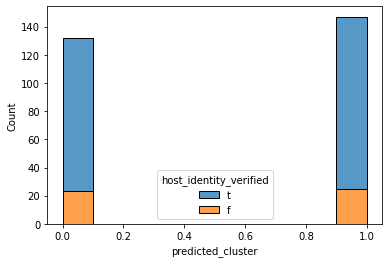

In [113]:
cat_att = ['neighborhood','property_type','room_type','host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified']
for col in cat_att:
    sns.histplot(x='predicted_cluster', multiple = "stack", hue = col , data = df_combo)
    plt.show()

### 5.2. Clustering with k=3 Clusters

Next, let's examine *just* the two *new* clusters that were created when we split one of the clusters going from the clustering with k=2 clusters to the clustering with k=3 clusters.

#### 5.2.1. Finding the cluster labels

First, in the clustering with k=3 clusters, what are the cluster labels belonging to these two clusters that were created by splitting one of the clusters in the clustering with k=2 clusters?

For categorical variables, property type, room type, and neighborhood characterizes these 2 clusters. For numerical variables, price, cleaning_fee, and number_of_bathrooms characterizes these 2 clusters.

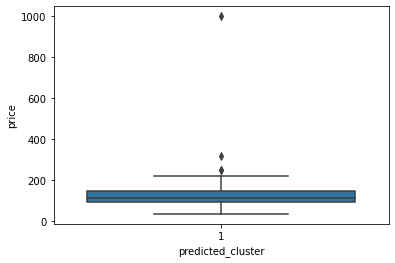

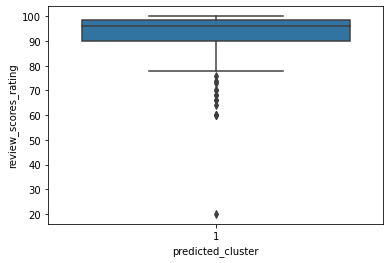

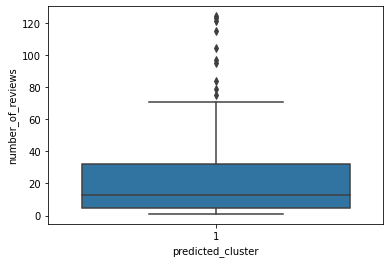

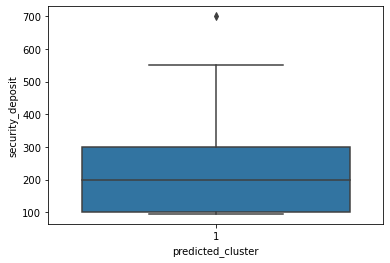

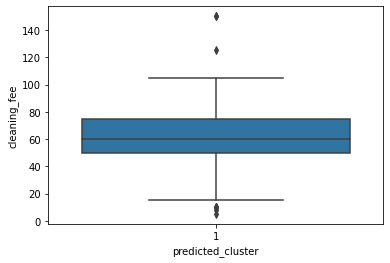

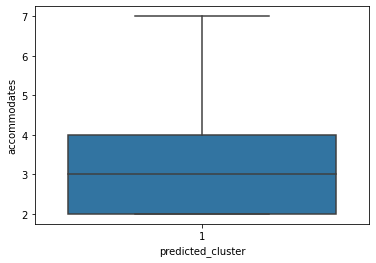

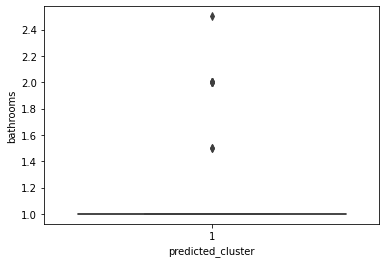

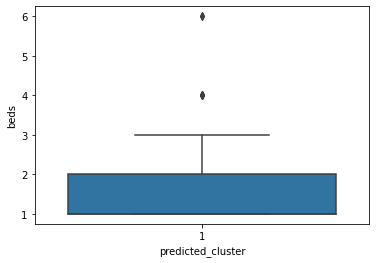

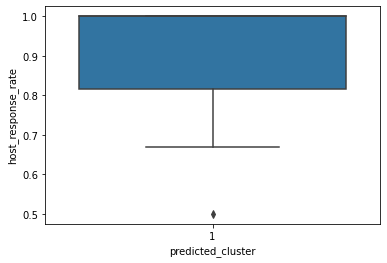

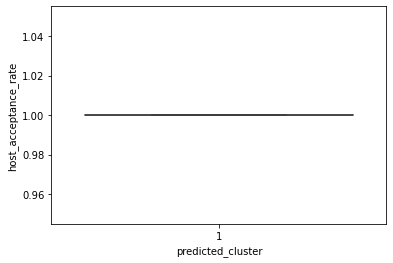

In [127]:
for col in att:
    sns.boxplot(x="predicted_cluster", y=col, data=X)
    plt.show()

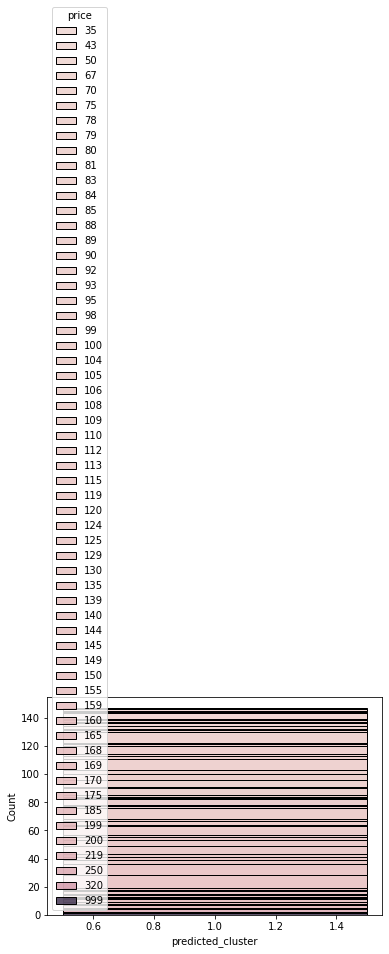

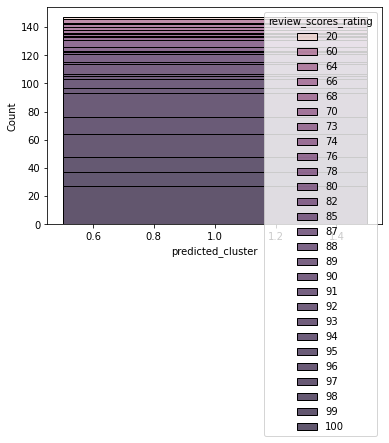

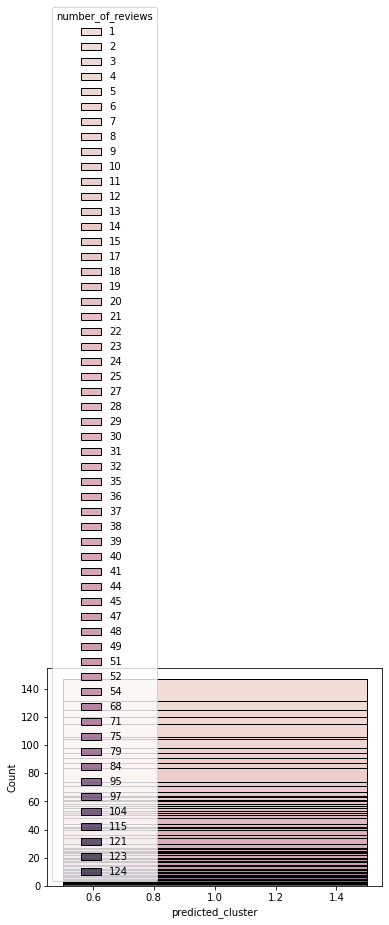

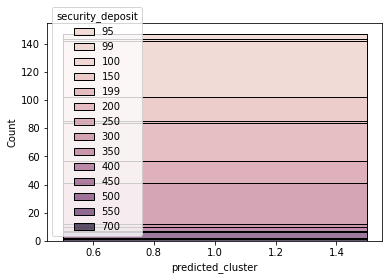

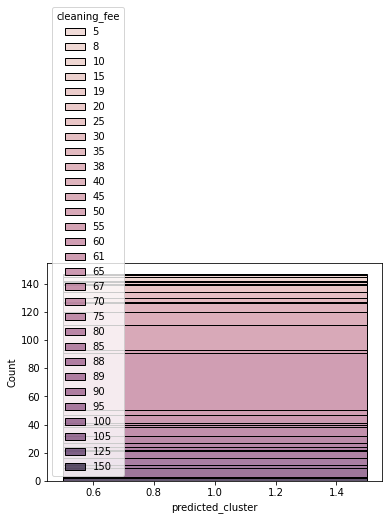

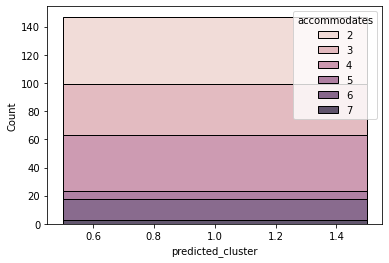

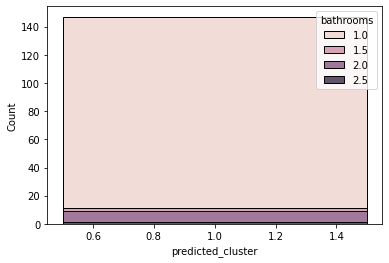

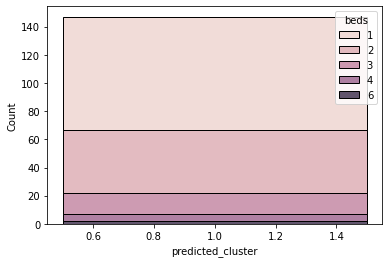

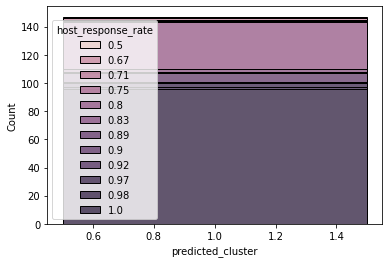

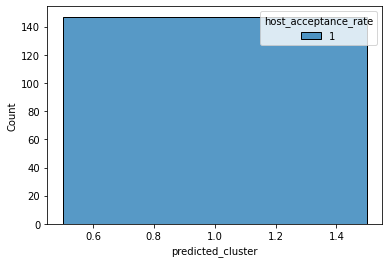

In [131]:
for col in att:
    sns.histplot(x='predicted_cluster', multiple="stack", hue=col , data=X)
    plt.show()

#### 5.2.2. Cluster Characterization

We can think of these two clusters as the second most distinct set of clusters in the dataset (according to the complete linkage function).

What attributes had a strong association with these two newly formed clusters? What attribute values characterize these two clusters in this dataset? You should examine both the numerical and categorical attributes here. For the numerical attributes, make sure that you look at the **unscaled data**.


For categorical variable, the attributes that have strong association is neighborhood, property_type, and room_type. For numerical variable, the attributes that have strong association is price, host_response_rate. and cleaning_fee/.

<hr>

## <u>Case Study 2</u>: Seattle Airbnb Listing Analysis - Reduced Dataset - *Just Categorical Variables*

Next, we would like to try clustering our Airbnb listing dataset now using just the categorical variables. How will our results differ when just considering the categorical variables?

## 6. Data Preprocessing and Cleaning

### 6.1. Categorical Dataset

Next, create a dataframe that is just comprised of the categorical variables.

In [132]:
catnew = cat.copy()
catnew

neighborhood property_type        room_type  host_response_time  \
0    Wallingford         House  Entire home/apt  within a few hours   
1    Wallingford     Apartment  Entire home/apt      within an hour   
2    Wallingford     Apartment  Entire home/apt      within an hour   
3    Wallingford         House     Private room  within a few hours   
4    Wallingford         House  Entire home/apt      within an hour   
..           ...           ...              ...                 ...   
274      Fremont         House  Entire home/apt  within a few hours   
275      Fremont     Apartment  Entire home/apt  within a few hours   
276      Fremont     Apartment  Entire home/apt      within an hour   
277      Fremont         House  Entire home/apt  within a few hours   
278      Fremont         House  Entire home/apt      within an hour   

    host_is_superhost host_has_profile_pic host_identity_verified  
0                   t                    t                      t  
1                   f                    t                      t  
2                   f                    t                      t  
3                   t                    t                      t  
4                   t                    t                      t  
..                ...                  ...                    ...  
274                 f                    t                      t  
275                 t                    t                      t  
276                 f                    t                      t  
277                 f                    t                      t  
278                 f                    t                      t  

[279 rows x 7 columns]

### 6.2. Hamming distance matrix

Finally, create a Hamming distance matrix of your categorical variables.

In [133]:
from kmodes.kmodes import KModes
from sklearn import preprocessing

catnew = cat.copy()
catnew

neighborhood property_type        room_type  host_response_time  \
0    Wallingford         House  Entire home/apt  within a few hours   
1    Wallingford     Apartment  Entire home/apt      within an hour   
2    Wallingford     Apartment  Entire home/apt      within an hour   
3    Wallingford         House     Private room  within a few hours   
4    Wallingford         House  Entire home/apt      within an hour   
..           ...           ...              ...                 ...   
274      Fremont         House  Entire home/apt  within a few hours   
275      Fremont     Apartment  Entire home/apt  within a few hours   
276      Fremont     Apartment  Entire home/apt      within an hour   
277      Fremont         House  Entire home/apt  within a few hours   
278      Fremont         House  Entire home/apt      within an hour   

    host_is_superhost host_has_profile_pic host_identity_verified  
0                   t                    t                      t  
1                   f                    t                      t  
2                   f                    t                      t  
3                   t                    t                      t  
4                   t                    t                      t  
..                ...                  ...                    ...  
274                 f                    t                      t  
275                 t                    t                      t  
276                 f                    t                      t  
277                 f                    t                      t  
278                 f                    t                      t  

[279 rows x 7 columns]

In [146]:
X = catnew.copy()
ham = {}
for col in catnew.columns:
    ham[col] = preprocessing.LabelEncoder()
    X[col] = label_encode[col].fit_transform(catnew[col])
    print(col)

neighborhood
property_type
room_type
host_response_time
host_is_superhost
host_has_profile_pic
host_identity_verified


In [147]:
X.head()

neighborhood  property_type  room_type  host_response_time  \
0             4              1          0                   1   
1             4              0          0                   2   
2             4              0          0                   2   
3             4              1          1                   1   
4             4              1          0                   2   

   host_is_superhost  host_has_profile_pic  host_identity_verified  
0                  1                     1                       1  
1                  0                     1                       1  
2                  0                     1                       1  
3                  1                     1                       1  
4                  1                     1                       1

In [149]:
dist_mat = squareform(pdist(X, metric='hamming'))
dist_mat

array([[0.        , 0.42857143, 0.42857143, ..., 0.57142857, 0.28571429,
        0.42857143],
       [0.42857143, 0.        , 0.        , ..., 0.14285714, 0.42857143,
        0.28571429],
       [0.42857143, 0.        , 0.        , ..., 0.14285714, 0.42857143,
        0.28571429],
       ...,
       [0.57142857, 0.14285714, 0.14285714, ..., 0.        , 0.28571429,
        0.14285714],
       [0.28571429, 0.42857143, 0.42857143, ..., 0.28571429, 0.        ,
        0.14285714],
       [0.42857143, 0.28571429, 0.28571429, ..., 0.14285714, 0.14285714,
        0.        ]])

## 7. Clusterability

### 7.1. t-SNE Plots
Using 6 different perplexity values and at least two random states for each perplexity value, map this **distance matrix** onto a two-dimensional dataset with the t-SNE algorithm. Show your projected coordinates in a scatterplot for each combination of random states and perplexity value.

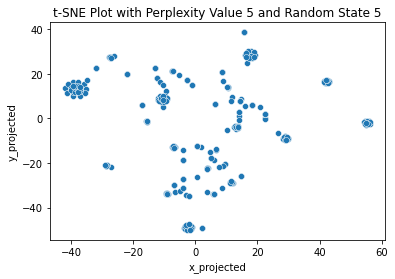

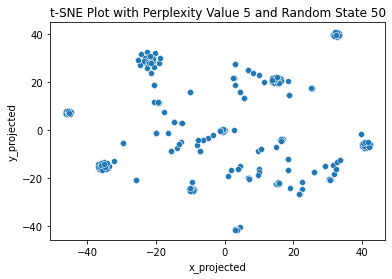

--------------------------------------------


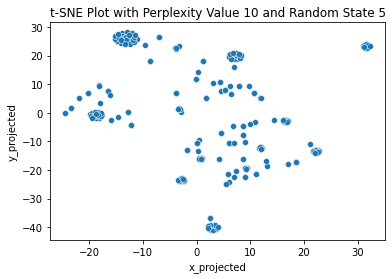

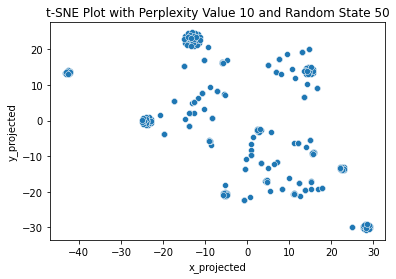

--------------------------------------------


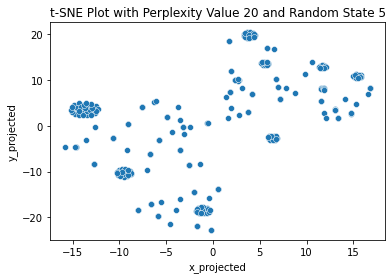

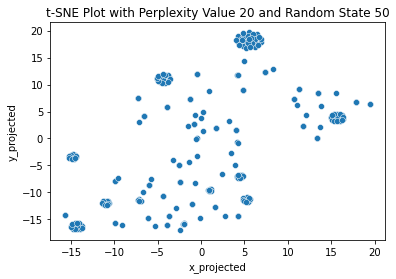

--------------------------------------------


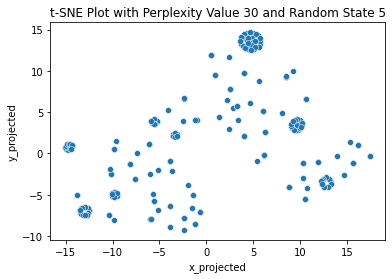

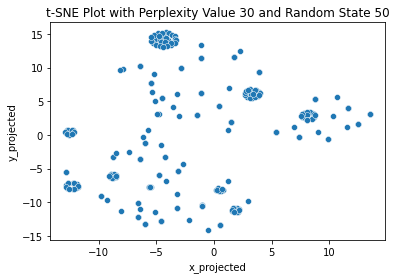

--------------------------------------------


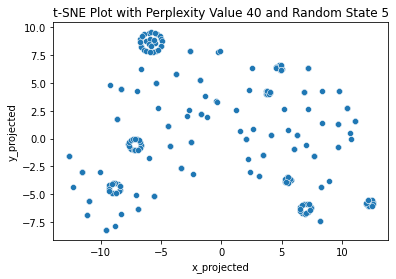

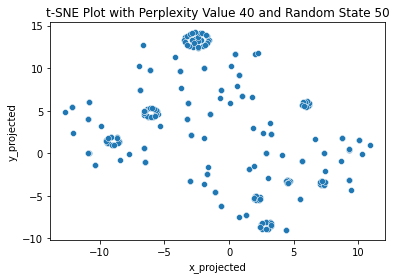

--------------------------------------------


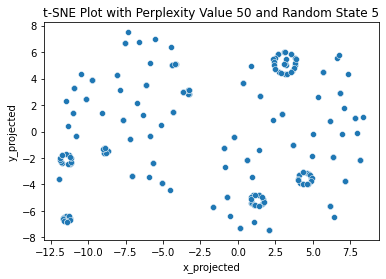

In [ ]:
for perp in [5,10, 20, 30, 40, 50]:
    for rs in [5,50]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed')
        data_tsne = tsne.fit_transform(dist_mat)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([df, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()
    print('--------------------------------------------')

### 7.2 Assessing Clustering Structure

Answer the following questions below.

1. Does the t-SNE algorith suggest that this dataset is clusterable?
2. How many "main clusters" do you think that this dataset has? *[Subjective Answer: As long as your logic is correct, you will not lose points].*

Finally, pick out a random state and perplexity value that reflects the answers to your questions and show the corresponding t-SNE plot below.


1. The t-SNE algorithm suggest this dataset is clusterable
2. Looking at the plot below of perplexity value 30 and random state 5, there are at least 2 main clusters.

In [ ]:
for perp in [30]:
    for rs in [5]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed')
        data_tsne = tsne.fit_transform(dist_mat)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([df, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()

### 7.3. Association between the Attributes and the Clustering Structure Suggested by the t-SNE Plots

Finally, we would like to assess how each of our 7 categorical attributes is individually associated with the clustering structure suggested by our selected t-SNE from 7.2. In the code below, plot your t-SNE plot 7 times, each time color coding the points by each of the 7 categorical attributes.

In [ ]:
categ = catnew.columns
categ

In [ ]:
for i in categ:
    for perp in [30]:
        for rs in [5]:
            tsne = TSNE(n_components=2, perplexity=perp, random_state=rs, metric='precomputed')
            data_tsne = tsne.fit_transform(dist_mat)
            df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
            df_combo = pd.concat([df, df_tsne], axis=1)
            sns.scatterplot(x='x_projected',y='y_projected', hue = cat, data=df_combo)
            plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
            plt.show()

### 7.4. Interpretation

Select one of the smaller *highly* dense clouds of points in your t-SNE plot. Do the categorical attribute values in the points in this dense cloud that you selected differ at all?

The categorical attribute values don;t differ in highly dense clouds, as seen in the plots above.

## 8. K-Modes - *Parameter Selection*

Next, we would like to cluster this dataset with the k-modes algorithm. We would like to explore what the best values of $k$  would be to use in this clustering algorithm to meet our research goals.


### 8.1. Elbow Plot

Create an elbow plot for the k-modes algorithm. Your plot should assess clusterings with k=1, k=2,..., k=16 clusters. For each k, run a single k-modes algorithm, using a random state of 100.

In [ ]:
cost = []

for num_clusters in list(range(1,17)):
    cost_sub_list=[]
    
    for j in range(0,3):
        kmode = KModes(n_clusters=num_clusters, random_state = 100)
        kmode.fit_predict(X2)
        cost_sub_list.append(kmode.cost_)
    cost.append(np.average(cost_sub_list))

In [ ]:
plt.plot(list(range(1,17)),cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for k-Modes')
plt.show()

### 8.2. t-SNE Plots

For k=1, k=2,..., k=10, run the k-modes clustering algorithm on your dataset, using a random state of 100. For each of your clusterings, plot a t-SNE plot in which you have color coded the points by their cluster labels.

In [ ]:
for num_clusters in list(range(1,11)):
    kmode = KModes(n_clusters=num_clusters, random_state = 100)
    cluster_labels = kmode.fit_predict(X2)
    df_combo['predicted_cluster']=cluster_labels
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", num_clusters), data=df_combo)
    plt.title('t-SNE Plot with k-Modes with k=%s Clusters' %(num_clusters))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    print('--------------------------------------------')

### 8.3. Interpretation

How many clusters does your elbow plot suggest are in this dataset? Does the k-modes clustering with this k number of clusters *strongly* agree with the clustering structured suggested by the t-SNE plot?



6 clusters is suggest by the elbow plot as that's where it levels off. The k-modes clustering don't strongly agree with the t-SNE plot.

## 9. Hierarchical Agglomerative Clustering

Next, we would like to cluster our Hamming distance matrix with hierarchical agglomerative clustering using single linkage, complete linkage, and average linkage.



### 9.1. Single Linkage

#### 9.1.1. Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with single linkage for using your Hamming distance matrix. 
* Because this is a small dataset, we do not need/want to truncate our dendrogram results. You should be able to see the indices of each of your observations at the leaves of your dendrogram tree.
* Make sure you are able to read the indices labels in your dendrogram.

In [ ]:
Z = linkage(dist_mat, method='single')
Z

In [ ]:
fig, ax = plt.subplots(figsize=(25, 30))
d = dendrogram(Z, orientation='right', ax=ax, truncate_mode='lastp', p=200, no_labels=True)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Bank Customers', fontsize=18)
plt.yticks(fontsize=12)
plt.title('Single Linkage', fontsize=18)
plt.show()

#### 9.1.2 [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=10 clusters, color code the points in your selected t-SNE plot with the respective cluster labels.

In [ ]:
for k in range(2,11):
    hac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='single')
    df_combo['predicted_cluster'] = hac.fit_predict(dist_mat)
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Single Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 9.2. Complete Linkage

#### 9.2.1. Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with complete linkage using your Hamming distance matrix.
* Because this is a small dataset, we do not need/want to truncate our dendrogram results. You should be able to see the indices of each of your observations at the leaves of your dendrogram tree.
* Make sure you are able to read the indices labels in your dendrogram.

In [ ]:
Z = linkage(dist_mat, method='complete')
Z

In [ ]:
fig, ax = plt.subplots(figsize=(25, 30))
d = dendrogram(Z, orientation='right', ax=ax, truncate_mode='lastp', p=200, no_labels=True)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Bank Customers', fontsize=18)
plt.yticks(fontsize=12)
plt.title('Single Linkage', fontsize=18)
plt.show()

#### 9.2.2 [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=10 clusters, color code the points in your selected t-SNE plot with the respective cluster labels.

In [ ]:
for k in range(2,11):
    hac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='complete')
    df_combo['predicted_cluster'] = hac.fit_predict(dist_mat)
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Complete Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

### 9.3. Average Linkage

#### 9.3.1. Dendrogram

Create a dendrogram using hierarchical agglomerative clustering with average linkage using your Hamming distance matrix.
* Because this is a small dataset, we do not need/want to truncate our dendrogram results. You should be able to see the indices of each of your observations at the leaves of your dendrogram tree.
* Make sure you are able to read the indices labels in your dendrogram.

In [ ]:
Z = linkage(dist_mat, method='average')
Z

In [ ]:
fig, ax = plt.subplots(figsize=(25, 30))
d = dendrogram(Z, orientation='right', ax=ax, truncate_mode='lastp', p=200, no_labels=True)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Bank Customers', fontsize=18)
plt.yticks(fontsize=12)
plt.title('Single Linkage', fontsize=18)
plt.show()

#### 9.2.2 [0.5 pt] t-SNE Individual Clustering Visualization

Then for each of the clusterings with k=2,k=3,...,k=10 clusters, color code the points in your selected t-SNE plot with the respective cluster labels.

In [ ]:
for k in range(2,11):
    hac = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='average')
    df_combo['predicted_cluster'] = hac.fit_predict(dist_mat)
    sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", k), data=df_combo)
    plt.title('t-SNE Plot with Average Linkage Clustering with k=%s Clusters' %(k))
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

## More information (if you're interested)

In a full analysis, it would also be insightful to do the following.

1. Create a t-SNE plot with just the numerical variables and run a numerical clustering algorithm on the numerical dataset (like k-means).

2. Then select your besting clusterings that you found with the a.) full mixed dataset, b.) the categorical variables dataset, and the c.) numerical variables dataset.

3. To what extent do these clusterings agree? You could use the adjusted rand score, homogeneity score, completeness score, V-score (or other clustering comparison metrics) to compare them.

